# RPCA Anomaly Detector

In [1]:
import numpy as np
import os
import sys
import pandas as pd
from dateutil import parser
import scipy.sparse

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
import itertools

import datetime
import time
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, precision_recall_fscore_support
from random import randint

In [3]:
SP500_INDEX_LEVELS = r'C:\phd\rpca\input\prices\GSPC.csv'
SP500_ANOMALY_THRESHOLD = 0.015
TICKER_ANOMALY_THRESHOLD = 0.0001
BASE_OUTPUT_DIR = r'C:\phd\rpca\output'

#### FUNCTIONS TO LOAD S&P 500 DATA

In [4]:
def get_returns_daily_df(filename):
    """Load the data and calculate log return.  Remove the 
    first row because it will always be NaN."""
    df = pd.read_csv(filename) 
    df.set_index(df['Dates'], inplace=True)
    df.drop('Dates', axis=1, inplace=True)
    df_ret = np.log(df / df.shift())
    return df_ret.iloc[1:]

def train_test_split(df, training_pct, validation_pct):
    training_set_end_idx = int(df.shape[0] * training_pct)
    validation_set_end_idx = int(df.shape[0] * (training_pct+ validation_pct))
    m_training = df[0:training_set_end_idx].copy()
    m_validation = df[training_set_end_idx:validation_set_end_idx].copy()
    m_test = df[validation_set_end_idx:].copy()
    return m_training, m_validation, m_test

"""
This method has been modified to account for polarity.  No winsorizing is done.  So if the 
entry is greater than 0, then it is positive.  If it is less than 0, it is untouched.
"""
def set_anomalies(x, upperThreshold, lowerThreshold, polarity=True):
    anomaly = 0
    if x >= upperThreshold:
        anomaly = 1
    elif x <= lowerThreshold:
        if polarity == True:
            anomaly = -1
        else:
            anomaly = 1
    else:
        anomaly = 0
    return anomaly
    
def get_sp500_anomalies(df, upperThreshold, lowerThreshold, polarity=True):
    df_anomalies = df.copy()
    df_anomalies.drop('Adj Close', axis=1, inplace=True)
    upperThreshold = np.percentile(df_anomalies['Return'], upperThreshold)
    lowerThreshold = np.percentile(df_anomalies['Return'], lowerThreshold)
    df_anomalies['Anomaly'] = df_anomalies['Return'].apply(set_anomalies, 
                                                           upperThreshold=upperThreshold, 
                                                           lowerThreshold=lowerThreshold,
                                                           polarity=polarity)
    return df_anomalies

def set_target_anomalies(df, upperBound, lowerBound):
    df_anomalies = df.copy()
    df_anomalies['Anomaly'] = df_anomalies['Return'].apply(set_target, 
                                                           upperBound=upperBound, 
                                                           lowerBound=lowerBound)
    return df_anomalies

def set_target(x, upperBound, lowerBound):
    anomaly = 0
    if x >= upperBound:
        anomaly = 1
    elif x <= lowerBound:
        anomaly = -1
    else:
        anomaly = 0
    return anomaly

def get_target_anomalies(df, upperBound, lowerBound):
    df_anomalies = df.copy()
    df_anomalies.drop('Adj Close', axis=1, inplace=True)
    df_anomalies['Anomaly'] = df_anomalies['Return'].apply(set_target, 
                                                           upperBound=upperBound, 
                                                           lowerBound=lowerBound)
    return df_anomalies

def get_anomalies_dfs(df_training, df_val, df_test, upperThreshold, lowerThreshold, polarity=True):
    df_training_anomalies = df_training.copy()
    df_training_anomalies.drop('Adj Close', axis=1, inplace=True)
    upperThreshold = np.percentile(df_training_anomalies['Return'], upperThreshold)
    lowerThreshold = np.percentile(df_training_anomalies['Return'], lowerThreshold)
    df_training_anomalies['Anomaly'] = df_training_anomalies['Return'].apply(set_anomalies, 
                                                           upperThreshold=upperThreshold, 
                                                           lowerThreshold=lowerThreshold,
                                                           polarity=polarity)
    df_val_anomalies = df_val.copy()
    df_val_anomalies.drop('Adj Close', axis=1, inplace=True)
    df_val_anomalies['Anomaly'] = df_val_anomalies['Return'].apply(set_anomalies, 
                                                           upperThreshold=upperThreshold, 
                                                           lowerThreshold=lowerThreshold,
                                                           polarity=polarity)

    df_test_anomalies = df_test.copy()
    df_test_anomalies.drop('Adj Close', axis=1, inplace=True)
    df_test_anomalies['Anomaly'] = df_test_anomalies['Return'].apply(set_anomalies, 
                                                           upperThreshold=upperThreshold, 
                                                           lowerThreshold=lowerThreshold,
                                                           polarity=polarity)

    
    return df_training_anomalies, df_val_anomalies, df_test_anomalies

def load_matrices(root_dir, lam):
    file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_S.npz')
    sparse_matrix = scipy.sparse.load_npz(file_path)
    dense_matrix = sparse_matrix.todense()
    
    u_file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_U.dat')
    e_file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_E.dat')
    vt_file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_VT.dat')
    
    U = np.load(u_file_path)
    E = np.load(e_file_path)
    VT = np.load(vt_file_path)
    
    return sparse_matrix, dense_matrix, U, E, VT

def load_sparse_matrix(root_dir, lam):
    file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_S.npz')
    sparse_matrix = scipy.sparse.load_npz(file_path)
    dense_matrix = sparse_matrix.todense()
    return dense_matrix

def get_full_path_2_save(root_dir, filename):
    full_path = os.path.join(root_dir, filename)    
    return full_path

def get_output_root_dir(dataset_type, input_type):
    output_root_dir = BASE_OUTPUT_DIR
    full_path = os.path.join(os.path.join(BASE_OUTPUT_DIR, input_type), dataset_type)    
    return full_path


"""
 Calculate the upper and lower cutoff points during training.  This cutoff is 
 based on the upper and lower percentile.  One this is decided, do no change it.
 Use the same cutoffs for valiation and testing.
"""
def get_sparse_df_from_matrix(S, sp500_anomalies, topPercentile, bottomPercentile, 
                              upperThreshold, lowerThreshold, isTraining=False):
    # set small entries to 0
    S[abs(S) < TICKER_ANOMALY_THRESHOLD] = 0        
    
    # -----------------------------------------
    # count positive
    # count negative
    # count 0's
    # calculate the ratio
    # ----------------------------------------
    P = (S > 0 ).sum(axis=1)
    N = (S < 0 ).sum(axis=1)
    Z = (S == 0).sum(axis=1)
    M = np.concatenate((P, N, Z), axis=1)
    
    S_df = pd.DataFrame(M, columns=['P', 'N', 'Z'])
    S_df.index = pd.to_datetime(sp500_anomalies.index)
    S_df['PNR'] = S_df['P'] / S_df['N']
    if isTraining:
        upperCutoff = np.percentile(S_df['PNR'], topPercentile)
        lowerCutoff = np.percentile(S_df['PNR'], bottomPercentile)
    else:
        upperCutoff = upperThreshold
        lowerCutoff = lowerThreshold
        
#     print("\t\t isTraining = {0}, upperCutoff = {1:.5f}, lowerCutoff = {2:.5f}".format(isTraining, upperCutoff, lowerCutoff))
    
    S_df['Anomaly'] = S_df['PNR'].apply(set_anomalies, upperThreshold=upperCutoff, lowerThreshold=lowerCutoff)
    S_df['upperCutoff'] = upperCutoff
    S_df['lowerCutoff'] = lowerCutoff
    return S_df, upperCutoff, lowerCutoff     

def get_features(lambda_multiplier, sp500_anomalies, input_type, data_type):
    output_root_dir = get_output_root_dir(data_type, input_type)
    S_training = load_sparse_matrix(output_root_dir, lambda_multiplier)
    S_training_df, S = get_features_from_matrix(S_training, sp500_anomalies)
    return S_training_df, S

def get_features_from_matrix(S, sp500_anomalies):
    S[abs(S) < TICKER_ANOMALY_THRESHOLD] = 0            
    nrows = S.shape[0]
    ncols = S.shape[1]

    P_list = []
    N_list = []
    Z_list = []
    P_avg_list = []
    N_avg_list = []
    PNR_list = []

    for i in np.arange(nrows):
        P = 0
        N = 0
        Z = 0
        P_avg = 0
        P_total = 0
        N_avg = 0
        N_total = 0
        PNR = 0
        for j in np.arange(ncols):
            if S[i,j] > 0:
                P = P + 1
                P_total = P_total + S[i,j]
            elif S[i,j] < 0:
                N = N + 1
                N_total = N_total + S[i,j]
            else:
                Z = Z + 1
        
        if P != 0:
            P_avg = P_total / P
        if N != 0:
            N_avg = N_total / N
            PNR = P/N
        
            
        P_list.append(P)
        N_list.append(N)
        Z_list.append(Z)
        P_avg_list.append(P_avg)
        N_avg_list.append(N_avg)
        PNR_list.append(PNR)

    S_df = pd.DataFrame()
    
    S_df['P'] = P_list
    S_df['N'] = N_list
    S_df['Z'] = Z_list
    S_df['P_avg'] = P_avg_list
    S_df['N_avg'] = N_avg_list
    S_df['PNR'] = PNR_list    
    S_df.index = pd.to_datetime(sp500_anomalies.index)
    return S_df, S     


def get_sparse_dfs(input_type, lambda_multiplier, Y_training_anomalies, 
                   Y_validation_anomalies, Y_test_anomalies, topPercentile, bottomPercentile):
    output_root_dir = get_output_root_dir("training", input_type)
    S_training = load_sparse_matrix(output_root_dir, lambda_multiplier)
#     print("\tinput_type = {0:s}, now calling get_sparse_df_from_matrix with isTraining as True".format(input_type))
    S_training_df, upperCutoff, lowerCutoff = get_sparse_df_from_matrix(S_training, 
                                                                        Y_training_anomalies, 
                                                                        topPercentile,
                                                                        bottomPercentile,
                                                                        None, 
                                                                        None,
                                                                        True)
#     print("\tupperCutoff = {0:.5f}, lowerCutoff = {1:.5f}".format(upperCutoff, lowerCutoff))

    output_root_dir = get_output_root_dir("validation", input_type)
    S_validation = load_sparse_matrix(output_root_dir, lambda_multiplier)
#     print("\tinput_type = {0:s}, now calling get_sparse_df_from_matrix with isTraining as False; validation".format(input_type))
    S_validation_df, upperCutoff, lowerCutoff = get_sparse_df_from_matrix(S_validation, 
                                                      Y_validation_anomalies, 
                                                      None,
                                                      None,
                                                      upperCutoff, 
                                                      lowerCutoff, 
                                                      False)
#     print("\tupperCutoff = {0:.5f}, lowerCutoff = {1:.5f}".format(upperCutoff, lowerCutoff))
    
    output_root_dir = get_output_root_dir("test", input_type)
    S_test = load_sparse_matrix(output_root_dir, lambda_multiplier)
#     print("\tinput_type = {0:s}, now calling get_sparse_df_from_matrix with isTraining as False; test".format(input_type))
    S_test_df, upperCutoff, lowerCutoff = get_sparse_df_from_matrix(S_test, 
                                                Y_test_anomalies, 
                                                None, 
                                                None,
                                                upperCutoff,
                                                lowerCutoff,
                                                False)
#     print("\tupperCutoff = {0:.5f}, lowerCutoff = {1:.5f}".format(upperCutoff, lowerCutoff))
    return S_training_df, S_validation_df, S_test_df
        

def get_train_val_test(S_training_df, S_validation_df, S_test_df):
    X_train = S_training_df.iloc[4:,].copy().as_matrix()
    y_train = Y_training_anomalies.iloc[4:,1].copy().as_matrix()
    y_train = np.reshape(y_train,-1)

    X_val = S_validation_df.iloc[4:,].copy().as_matrix()
    y_val = Y_validation_anomalies.iloc[4:,1].copy().as_matrix()
    y_val = np.reshape(y_val,-1)

    X_test = S_test_df.iloc[4:,].copy().as_matrix()
    y_test = Y_test_anomalies.iloc[4:,1].copy().as_matrix()
    y_test = np.reshape(y_test,-1)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def get_metrics(y_train, y_pred):
    precision = f1_score(y_train, y_pred, average="macro")
    recall = recall_score(y_train, y_pred, average="macro")
    f1 = (2*precision*recall)/(precision+recall)
    return precision, recall, f1    

### Execute code from below

In [10]:
# Decide what is an anomaly, by labeling days with 
# absolute return above a threshold as anomalies
sp500_df = pd.read_csv(SP500_INDEX_LEVELS)
sp500_df = sp500_df.set_index('Date')
sp500_df.index = pd.to_datetime(sp500_df.index)
df_ = sp500_df[['Adj Close']].copy()
df_returns = np.log(df_/df_.shift())
sp500_returns_df = df_returns.iloc[1:].copy()
sp500_returns_df.columns = ['Return']
sp500_returns_df['Adj Close'] = df_.loc[sp500_returns_df.index]['Adj Close']

# Split the data set and decide what is an anomaly
split_pct = 0.66
validation_pct = 0.17
# X_training_df, X_validation_df, X_test_df = train_test_split(constituents_returns_df, split_pct, validation_pct)
sp500_training_df, sp500_validation_df, sp500_test_df = train_test_split(sp500_returns_df, split_pct, validation_pct)

### Simulation for Returns 

Let us first find the threshold, the $\alpha$

In [86]:
alphas = np.linspace(0.005, 0.015, 25)
lam_multiplier = 1

S_training_df, S = get_features(lam_multiplier, Y_training_anomalies, "returns", "training")
X = S_training_df.copy()

for alpha in alphas:
    upperBound = alpha
    lowerBound = -1*alpha
    
    Y_training_anomalies = get_target_anomalies(sp500_training_df.copy(), upperBound, lowerBound)            
    y = Y_training_anomalies['Anomaly']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    pred_y = clf.predict(X_test)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=1.0, average="weighted")
    _, _recall, f2_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=2.0, average="weighted")
    unique_vals = len(np.unique( pred_y ))
    print("{6:d}, {7:f}%, {8:f}%, {0:f}, {1:f}, {2:f}, {3:f}, {4:f}, {5:f}".format(alpha, precision, 
                                                                                 recall, f1_score, f2_score, unique_vals,
                                                                                lam_multiplier, upperBound*100, lowerBound*100))

1, 0.500000%, -0.500000%, 0.005000, 0.715853, 0.715746, 0.715505, 0.715580, 3.000000
1, 0.541667%, -0.541667%, 0.005417, 0.719648, 0.719836, 0.719331, 0.719539, 3.000000
1, 0.583333%, -0.583333%, 0.005833, 0.737178, 0.738241, 0.736747, 0.737428, 3.000000
1, 0.625000%, -0.625000%, 0.006250, 0.760696, 0.760736, 0.760045, 0.760302, 3.000000
1, 0.666667%, -0.666667%, 0.006667, 0.786129, 0.787321, 0.785564, 0.786348, 3.000000
1, 0.708333%, -0.708333%, 0.007083, 0.798562, 0.795501, 0.795862, 0.795335, 3.000000
1, 0.750000%, -0.750000%, 0.007500, 0.812179, 0.811861, 0.810781, 0.811120, 3.000000
1, 0.791667%, -0.791667%, 0.007917, 0.850684, 0.848671, 0.848277, 0.848159, 3.000000
1, 0.833333%, -0.833333%, 0.008333, 0.827492, 0.826176, 0.826747, 0.826383, 3.000000
1, 0.875000%, -0.875000%, 0.008750, 0.868070, 0.867076, 0.867152, 0.866998, 3.000000
1, 0.916667%, -0.916667%, 0.009167, 0.854530, 0.854806, 0.854494, 0.854639, 3.000000
1, 0.958333%, -0.958333%, 0.009583, 0.856257, 0.856851, 0.856414,

After $\alpha$ we will use the validation set to determine $\lambda$

In [94]:
alpha = 0.013333
upperBound = alpha
lowerBound = -1*alpha

Y_validation_anomalies = get_target_anomalies(sp500_validation_df.copy(), upperBound, lowerBound)            
y = Y_validation_anomalies['Anomaly']

lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
            0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5]


for lam_multiplier in lam_list:    
    S_validation_df, S = get_features(lam_multiplier, Y_validation_anomalies, "returns", "validation")
    X = S_validation_df.copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    pred_y = clf.predict(X_test)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=1.0, average="weighted")
    _, _recall, f2_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=2.0, average="weighted")
    unique_vals = len(np.unique( pred_y ))
    print("{6:f}, {7:f}%, {8:f}%, {0:f}, {1:f}, {2:f}, {3:f}, {4:f}, {5:f}".format(alpha, precision, 
                                                                                 recall, f1_score, f2_score, unique_vals,
                                                                                lam_multiplier, upperBound*100, lowerBound*100))

0.050000, 1.333300%, -1.333300%, 0.013333, 0.961374, 0.944444, 0.949696, 0.945432, 3.000000
0.052600, 1.333300%, -1.333300%, 0.013333, 0.969037, 0.960317, 0.962807, 0.960689, 3.000000
0.055600, 1.333300%, -1.333300%, 0.013333, 0.971781, 0.952381, 0.957877, 0.953151, 3.000000
0.058800, 1.333300%, -1.333300%, 0.013333, 0.961374, 0.944444, 0.949696, 0.945432, 3.000000
0.062500, 1.333300%, -1.333300%, 0.013333, 0.976014, 0.960317, 0.964860, 0.960995, 3.000000
0.066700, 1.333300%, -1.333300%, 0.013333, 0.958908, 0.952381, 0.954821, 0.953106, 3.000000
0.071400, 1.333300%, -1.333300%, 0.013333, 0.974537, 0.960317, 0.964219, 0.960843, 3.000000
0.076900, 1.333300%, -1.333300%, 0.013333, 0.969037, 0.960317, 0.962807, 0.960689, 3.000000
0.083300, 1.333300%, -1.333300%, 0.013333, 0.969037, 0.960317, 0.962807, 0.960689, 3.000000
0.090900, 1.333300%, -1.333300%, 0.013333, 0.977045, 0.968254, 0.970297, 0.968359, 3.000000
0.100000, 1.333300%, -1.333300%, 0.013333, 0.976014, 0.960317, 0.964860, 0.96099

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


3.000000, 1.333300%, -1.333300%, 0.013333, 0.861175, 0.912698, 0.886189, 0.901906, 2.000000
4.000000, 1.333300%, -1.333300%, 0.013333, 0.870748, 0.873016, 0.871693, 0.872428, 3.000000
5.000000, 1.333300%, -1.333300%, 0.013333, 0.859504, 0.888889, 0.873950, 0.882852, 3.000000


Performance Metrics on the Test Data Set

In [95]:
lam_multiplier = 0.5
S_training_df, S = get_features(lam_multiplier, Y_training_anomalies, "returns", "training")
X_train = S_training_df.copy()

alpha = 0.013333
upperBound = alpha
lowerBound = -1*alpha
Y_training_anomalies = get_target_anomalies(sp500_training_df.copy(), upperBound, lowerBound)            
y_train = Y_training_anomalies['Anomaly']

lam_multiplier = 0.5
S_test_df, S = get_features(lam_multiplier, Y_test_anomalies, "returns", "test")
X_test = S_test_df.copy()

Y_test_anomalies = get_target_anomalies(sp500_test_df.copy(), upperBound, lowerBound)            
y_test = Y_test_anomalies['Anomaly']

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
pred_y = clf.predict(X_test)
    
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=1.0, average="weighted")
_, _recall, f2_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=2.0, average="weighted")
unique_vals = len(np.unique( pred_y ))
print("{6:f}, {7:f}%, {8:f}%, {0:f}, {1:f}, {2:f}, {3:f}, {4:f}, {5:f}".format(alpha, precision, 
                                                                                 recall, f1_score, f2_score, unique_vals,
                                                                                lam_multiplier, upperBound*100, lowerBound*100))

0.500000, 1.333300%, -1.333300%, 0.013333, 0.949374, 0.876984, 0.898271, 0.879783, 3.000000


### Euclidean Distance 

Let us first find the threshold, the $\alpha$

In [96]:
alphas = np.linspace(0.005, 0.015, 25)
lam_multiplier = 1

S_training_df, S = get_features(lam_multiplier, Y_training_anomalies, "euclidean-distances", "training")
X = S_training_df.copy()

for alpha in alphas:
    upperBound = alpha
    lowerBound = -1*alpha
    
    Y_training_anomalies = get_target_anomalies(sp500_training_df.copy(), upperBound, lowerBound)            
    y = Y_training_anomalies['Anomaly']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    pred_y = clf.predict(X_test)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=1.0, average="weighted")
    _, _recall, f2_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=2.0, average="weighted")
    unique_vals = len(np.unique( pred_y ))
    print("{6:d}, {7:f}%, {8:f}%, {0:f}, {1:f}, {2:f}, {3:f}, {4:f}, {5:f}".format(alpha, precision, 
                                                                                 recall, f1_score, f2_score, unique_vals,
                                                                                lam_multiplier, upperBound*100, lowerBound*100))

1, 0.500000%, -0.500000%, 0.005000, 0.553811, 0.572597, 0.559314, 0.566461, 3.000000
1, 0.541667%, -0.541667%, 0.005417, 0.564127, 0.593047, 0.572216, 0.583433, 3.000000
1, 0.583333%, -0.583333%, 0.005833, 0.589134, 0.619632, 0.599596, 0.610650, 3.000000
1, 0.625000%, -0.625000%, 0.006250, 0.637562, 0.662577, 0.644604, 0.654342, 3.000000
1, 0.666667%, -0.666667%, 0.006667, 0.654969, 0.676892, 0.658254, 0.668055, 3.000000
1, 0.708333%, -0.708333%, 0.007083, 0.668228, 0.693252, 0.676366, 0.685657, 3.000000
1, 0.750000%, -0.750000%, 0.007500, 0.703319, 0.725971, 0.707254, 0.717176, 3.000000
1, 0.791667%, -0.791667%, 0.007917, 0.694933, 0.709611, 0.697513, 0.703750, 3.000000
1, 0.833333%, -0.833333%, 0.008333, 0.739317, 0.748466, 0.740686, 0.744644, 3.000000
1, 0.875000%, -0.875000%, 0.008750, 0.748748, 0.752556, 0.750102, 0.751440, 3.000000
1, 0.916667%, -0.916667%, 0.009167, 0.755230, 0.766871, 0.757269, 0.762167, 3.000000
1, 0.958333%, -0.958333%, 0.009583, 0.762854, 0.779141, 0.769206,

After $\alpha$ we will use the validation set to determine $\lambda$

In [97]:
alpha = 0.015
upperBound = alpha
lowerBound = -1*alpha

Y_validation_anomalies = get_target_anomalies(sp500_validation_df.copy(), upperBound, lowerBound)            
y = Y_validation_anomalies['Anomaly']

lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
            0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5]


for lam_multiplier in lam_list:    
    S_validation_df, S = get_features(lam_multiplier, Y_validation_anomalies, "euclidean-distances", "validation")
    X = S_validation_df.copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    pred_y = clf.predict(X_test)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=1.0, average="weighted")
    _, _recall, f2_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=2.0, average="weighted")
    unique_vals = len(np.unique( pred_y ))
    print("{6:f}, {7:f}%, {8:f}%, {0:f}, {1:f}, {2:f}, {3:f}, {4:f}, {5:f}".format(alpha, precision, 
                                                                                 recall, f1_score, f2_score, unique_vals,
                                                                                lam_multiplier, upperBound*100, lowerBound*100))

0.050000, 1.500000%, -1.500000%, 0.015000, 0.938743, 0.912698, 0.925382, 0.917701, 3.000000
0.052600, 1.500000%, -1.500000%, 0.015000, 0.923280, 0.920635, 0.921769, 0.921053, 3.000000
0.055600, 1.500000%, -1.500000%, 0.015000, 0.931415, 0.936508, 0.933756, 0.935368, 3.000000
0.058800, 1.500000%, -1.500000%, 0.015000, 0.926984, 0.928571, 0.927690, 0.928193, 3.000000
0.062500, 1.500000%, -1.500000%, 0.015000, 0.928370, 0.920635, 0.924486, 0.922171, 3.000000
0.066700, 1.500000%, -1.500000%, 0.015000, 0.927183, 0.936508, 0.931741, 0.934572, 3.000000
0.071400, 1.500000%, -1.500000%, 0.015000, 0.939153, 0.944444, 0.941270, 0.943001, 3.000000
0.076900, 1.500000%, -1.500000%, 0.015000, 0.944577, 0.952381, 0.948463, 0.950810, 3.000000
0.083300, 1.500000%, -1.500000%, 0.015000, 0.936237, 0.920635, 0.928370, 0.923713, 3.000000
0.090900, 1.500000%, -1.500000%, 0.015000, 0.923545, 0.928571, 0.925853, 0.927444, 3.000000
0.100000, 1.500000%, -1.500000%, 0.015000, 0.940859, 0.920635, 0.930421, 0.92446

Performance Metrics on the Test Data Set

In [99]:
lam_multiplier = 0.0714
S_training_df, S = get_features(lam_multiplier, Y_training_anomalies, "euclidean-distances", "training")
X_train = S_training_df.copy()

alpha = 0.015
upperBound = alpha
lowerBound = -1*alpha
Y_training_anomalies = get_target_anomalies(sp500_training_df.copy(), upperBound, lowerBound)            
y_train = Y_training_anomalies['Anomaly']

lam_multiplier = 0.0714
S_test_df, S = get_features(lam_multiplier, Y_test_anomalies, "euclidean-distances", "test")
X_test = S_test_df.copy()

Y_test_anomalies = get_target_anomalies(sp500_test_df.copy(), upperBound, lowerBound)            
y_test = Y_test_anomalies['Anomaly']

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
pred_y = clf.predict(X_test)
    
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=1.0, average="weighted")
_, _recall, f2_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=2.0, average="weighted")
unique_vals = len(np.unique( pred_y ))
print("{6:f}, {7:f}%, {8:f}%, {0:f}, {1:f}, {2:f}, {3:f}, {4:f}, {5:f}".format(alpha, precision, 
                                                                                 recall, f1_score, f2_score, unique_vals,
                                                                                lam_multiplier, upperBound*100, lowerBound*100))

0.071400, 1.500000%, -1.500000%, 0.015000, 0.929774, 0.571429, 0.693006, 0.604527, 3.000000


### Symmetrical KL Divergence

Let us first find the threshold, the $\alpha$

In [100]:
alphas = np.linspace(0.005, 0.015, 25)
lam_multiplier = 1

S_training_df, S = get_features(lam_multiplier, Y_training_anomalies, "symmetrical-kl-divergence", "training")
X = S_training_df.copy()

for alpha in alphas:
    upperBound = alpha
    lowerBound = -1*alpha
    
    Y_training_anomalies = get_target_anomalies(sp500_training_df.copy(), upperBound, lowerBound)            
    y = Y_training_anomalies['Anomaly']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    pred_y = clf.predict(X_test)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=1.0, average="weighted")
    _, _recall, f2_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=2.0, average="weighted")
    unique_vals = len(np.unique( pred_y ))
    print("{6:d}, {7:f}%, {8:f}%, {0:f}, {1:f}, {2:f}, {3:f}, {4:f}, {5:f}".format(alpha, precision, 
                                                                                 recall, f1_score, f2_score, unique_vals,
                                                                                lam_multiplier, upperBound*100, lowerBound*100))

1, 0.500000%, -0.500000%, 0.005000, 0.481335, 0.490798, 0.483530, 0.487331, 3.000000
1, 0.541667%, -0.541667%, 0.005417, 0.502558, 0.521472, 0.508932, 0.515746, 3.000000
1, 0.583333%, -0.583333%, 0.005833, 0.486687, 0.511247, 0.494973, 0.503875, 3.000000
1, 0.625000%, -0.625000%, 0.006250, 0.504250, 0.550102, 0.521022, 0.537010, 3.000000
1, 0.666667%, -0.666667%, 0.006667, 0.554275, 0.578732, 0.563454, 0.571940, 3.000000
1, 0.708333%, -0.708333%, 0.007083, 0.552669, 0.586912, 0.565183, 0.577274, 3.000000
1, 0.750000%, -0.750000%, 0.007500, 0.559079, 0.597137, 0.573869, 0.586981, 3.000000
1, 0.791667%, -0.791667%, 0.007917, 0.590612, 0.631902, 0.606287, 0.620658, 3.000000
1, 0.833333%, -0.833333%, 0.008333, 0.634295, 0.670757, 0.647571, 0.660439, 3.000000
1, 0.875000%, -0.875000%, 0.008750, 0.646712, 0.674847, 0.657037, 0.667009, 3.000000
1, 0.916667%, -0.916667%, 0.009167, 0.674215, 0.713701, 0.683797, 0.699996, 3.000000
1, 0.958333%, -0.958333%, 0.009583, 0.669218, 0.717791, 0.684399,

After $\alpha$ we will use the validation set to determine $\lambda$

In [101]:
alpha = 0.015
upperBound = alpha
lowerBound = -1*alpha

Y_validation_anomalies = get_target_anomalies(sp500_validation_df.copy(), upperBound, lowerBound)            
y = Y_validation_anomalies['Anomaly']

lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
            0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5]


for lam_multiplier in lam_list:    
    S_validation_df, S = get_features(lam_multiplier, Y_validation_anomalies, "symmetrical-kl-divergence", "validation")
    X = S_validation_df.copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    pred_y = clf.predict(X_test)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=1.0, average="weighted")
    _, _recall, f2_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=2.0, average="weighted")
    unique_vals = len(np.unique( pred_y ))
    print("{6:f}, {7:f}%, {8:f}%, {0:f}, {1:f}, {2:f}, {3:f}, {4:f}, {5:f}".format(alpha, precision, 
                                                                                 recall, f1_score, f2_score, unique_vals,
                                                                                lam_multiplier, upperBound*100, lowerBound*100))

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.050000, 1.500000%, -1.500000%, 0.015000, 0.890255, 0.912698, 0.901337, 0.908120, 2.000000
0.052600, 1.500000%, -1.500000%, 0.015000, 0.891129, 0.928571, 0.909465, 0.920833, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.055600, 1.500000%, -1.500000%, 0.015000, 0.891556, 0.936508, 0.913479, 0.927158, 2.000000
0.058800, 1.500000%, -1.500000%, 0.015000, 0.922184, 0.936508, 0.925128, 0.931528, 3.000000
0.062500, 1.500000%, -1.500000%, 0.015000, 0.891129, 0.928571, 0.909465, 0.920833, 3.000000
0.066700, 1.500000%, -1.500000%, 0.015000, 0.891129, 0.928571, 0.909465, 0.920833, 3.000000
0.071400, 1.500000%, -1.500000%, 0.015000, 0.890696, 0.920635, 0.905418, 0.914487, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.076900, 1.500000%, -1.500000%, 0.015000, 0.891129, 0.928571, 0.909465, 0.920833, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.083300, 1.500000%, -1.500000%, 0.015000, 0.891556, 0.936508, 0.913479, 0.927158, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.090900, 1.500000%, -1.500000%, 0.015000, 0.891129, 0.928571, 0.909465, 0.920833, 2.000000
0.100000, 1.500000%, -1.500000%, 0.015000, 0.890696, 0.920635, 0.905418, 0.914487, 3.000000
0.111100, 1.500000%, -1.500000%, 0.015000, 0.890696, 0.920635, 0.905418, 0.914487, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.125000, 1.500000%, -1.500000%, 0.015000, 0.897612, 0.912698, 0.905093, 0.909641, 2.000000
0.142900, 1.500000%, -1.500000%, 0.015000, 0.898374, 0.928571, 0.913223, 0.922371, 3.000000
0.166700, 1.500000%, -1.500000%, 0.015000, 0.891129, 0.928571, 0.909465, 0.920833, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.200000, 1.500000%, -1.500000%, 0.015000, 0.890255, 0.912698, 0.901337, 0.908120, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.250000, 1.500000%, -1.500000%, 0.015000, 0.891129, 0.928571, 0.909465, 0.920833, 2.000000
0.330000, 1.500000%, -1.500000%, 0.015000, 0.888418, 0.880952, 0.884669, 0.882435, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.500000, 1.500000%, -1.500000%, 0.015000, 0.890255, 0.912698, 0.901337, 0.908120, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.000000, 1.500000%, -1.500000%, 0.015000, 0.914619, 0.944444, 0.927820, 0.937522, 2.000000
2.000000, 1.500000%, -1.500000%, 0.015000, 0.889807, 0.904762, 0.897222, 0.901731, 3.000000
3.000000, 1.500000%, -1.500000%, 0.015000, 0.908194, 0.920635, 0.914163, 0.917995, 3.000000
4.000000, 1.500000%, -1.500000%, 0.015000, 0.918711, 0.912698, 0.915601, 0.913830, 3.000000
5.000000, 1.500000%, -1.500000%, 0.015000, 0.887452, 0.865079, 0.876123, 0.869463, 3.000000


Performance Metrics on the Test Data Set

In [105]:
lam_multiplier = 0.0588
S_training_df, S = get_features(lam_multiplier, Y_training_anomalies, "symmetrical-kl-divergence", "training")
X_train = S_training_df.copy()

alpha = 0.015
upperBound = alpha
lowerBound = -1*alpha
Y_training_anomalies = get_target_anomalies(sp500_training_df.copy(), upperBound, lowerBound)            
y_train = Y_training_anomalies['Anomaly']

lam_multiplier = 0.0588
S_test_df, S = get_features(lam_multiplier, Y_test_anomalies, "symmetrical-kl-divergence", "test")
X_test = S_test_df.copy()

Y_test_anomalies = get_target_anomalies(sp500_test_df.copy(), upperBound, lowerBound)            
y_test = Y_test_anomalies['Anomaly']

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
pred_y = clf.predict(X_test)
    
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=1.0, average="weighted")
_, _recall, f2_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=2.0, average="weighted")
unique_vals = len(np.unique( pred_y ))
print("{6:f}, {7:f}%, {8:f}%, {0:f}, {1:f}, {2:f}, {3:f}, {4:f}, {5:f}".format(alpha, precision, 
                                                                                 recall, f1_score, f2_score, unique_vals,
                                                                                lam_multiplier, upperBound*100, lowerBound*100))

0.058800, 1.500000%, -1.500000%, 0.015000, 0.001741, 0.031746, 0.003298, 0.007118, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Asymmetrical KL Divergence

Let us first find the threshold, the $\alpha$

In [103]:
alphas = np.linspace(0.005, 0.015, 25)
lam_multiplier = 1

S_training_df, S = get_features(lam_multiplier, Y_training_anomalies, "asymmetrical-kl-divergence", "training")
X = S_training_df.copy()

for alpha in alphas:
    upperBound = alpha
    lowerBound = -1*alpha
    
    Y_training_anomalies = get_target_anomalies(sp500_training_df.copy(), upperBound, lowerBound)            
    y = Y_training_anomalies['Anomaly']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    pred_y = clf.predict(X_test)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=1.0, average="weighted")
    _, _recall, f2_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=2.0, average="weighted")
    unique_vals = len(np.unique( pred_y ))
    print("{6:d}, {7:f}%, {8:f}%, {0:f}, {1:f}, {2:f}, {3:f}, {4:f}, {5:f}".format(alpha, precision, 
                                                                                 recall, f1_score, f2_score, unique_vals,
                                                                                lam_multiplier, upperBound*100, lowerBound*100))

1, 0.500000%, -0.500000%, 0.005000, 0.415821, 0.439673, 0.422977, 0.431834, 3.000000
1, 0.541667%, -0.541667%, 0.005417, 0.436631, 0.458078, 0.443012, 0.451072, 3.000000
1, 0.583333%, -0.583333%, 0.005833, 0.471310, 0.498978, 0.479341, 0.489828, 3.000000
1, 0.625000%, -0.625000%, 0.006250, 0.503673, 0.539877, 0.514737, 0.528291, 3.000000
1, 0.666667%, -0.666667%, 0.006667, 0.514291, 0.548057, 0.522636, 0.536212, 3.000000
1, 0.708333%, -0.708333%, 0.007083, 0.519679, 0.562372, 0.532899, 0.549038, 3.000000
1, 0.750000%, -0.750000%, 0.007500, 0.576483, 0.613497, 0.580646, 0.597834, 3.000000
1, 0.791667%, -0.791667%, 0.007917, 0.571222, 0.611452, 0.584601, 0.599465, 3.000000
1, 0.833333%, -0.833333%, 0.008333, 0.611223, 0.648262, 0.623181, 0.637011, 3.000000
1, 0.875000%, -0.875000%, 0.008750, 0.646813, 0.672802, 0.649745, 0.662053, 3.000000
1, 0.916667%, -0.916667%, 0.009167, 0.631568, 0.676892, 0.648337, 0.664277, 3.000000
1, 0.958333%, -0.958333%, 0.009583, 0.658220, 0.711656, 0.673984,

After $\alpha$ we will use the validation set to determine $\lambda$

In [104]:
alpha = 0.01458333
upperBound = alpha
lowerBound = -1*alpha

Y_validation_anomalies = get_target_anomalies(sp500_validation_df.copy(), upperBound, lowerBound)            
y = Y_validation_anomalies['Anomaly']

lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
            0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5]


for lam_multiplier in lam_list:    
    S_validation_df, S = get_features(lam_multiplier, Y_validation_anomalies, "asymmetrical-kl-divergence", "validation")
    X = S_validation_df.copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    pred_y = clf.predict(X_test)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=1.0, average="weighted")
    _, _recall, f2_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=2.0, average="weighted")
    unique_vals = len(np.unique( pred_y ))
    print("{6:f}, {7:f}%, {8:f}%, {0:f}, {1:f}, {2:f}, {3:f}, {4:f}, {5:f}".format(alpha, precision, 
                                                                                 recall, f1_score, f2_score, unique_vals,
                                                                                lam_multiplier, upperBound*100, lowerBound*100))

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.050000, 1.458333%, -1.458333%, 0.014583, 0.876571, 0.928571, 0.901822, 0.917684, 2.000000
0.052600, 1.458333%, -1.458333%, 0.014583, 0.875597, 0.912698, 0.893763, 0.905029, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.055600, 1.458333%, -1.458333%, 0.014583, 0.877047, 0.936508, 0.905803, 0.923979, 1.000000
0.058800, 1.458333%, -1.458333%, 0.014583, 0.875597, 0.912698, 0.893763, 0.905029, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.062500, 1.458333%, -1.458333%, 0.014583, 0.875098, 0.904762, 0.889683, 0.898669, 2.000000
0.066700, 1.458333%, -1.458333%, 0.014583, 0.876088, 0.920635, 0.897809, 0.911367, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.071400, 1.458333%, -1.458333%, 0.014583, 0.876088, 0.920635, 0.897809, 0.911367, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.076900, 1.458333%, -1.458333%, 0.014583, 0.876571, 0.928571, 0.901822, 0.917684, 2.000000
0.083300, 1.458333%, -1.458333%, 0.014583, 0.875098, 0.904762, 0.889683, 0.898669, 3.000000
0.090900, 1.458333%, -1.458333%, 0.014583, 0.884955, 0.873016, 0.878578, 0.875108, 3.000000
0.100000, 1.458333%, -1.458333%, 0.014583, 0.876088, 0.920635, 0.897809, 0.911367, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.111100, 1.458333%, -1.458333%, 0.014583, 0.876571, 0.928571, 0.901822, 0.917684, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.125000, 1.458333%, -1.458333%, 0.014583, 0.876088, 0.920635, 0.897809, 0.911367, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.142900, 1.458333%, -1.458333%, 0.014583, 0.876088, 0.920635, 0.897809, 0.911367, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.166700, 1.458333%, -1.458333%, 0.014583, 0.876571, 0.928571, 0.901822, 0.917684, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.200000, 1.458333%, -1.458333%, 0.014583, 0.877047, 0.936508, 0.905803, 0.923979, 1.000000
0.250000, 1.458333%, -1.458333%, 0.014583, 0.883641, 0.928571, 0.905549, 0.919223, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.330000, 1.458333%, -1.458333%, 0.014583, 0.876571, 0.928571, 0.901822, 0.917684, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.500000, 1.458333%, -1.458333%, 0.014583, 0.875098, 0.904762, 0.889683, 0.898669, 2.000000
1.000000, 1.458333%, -1.458333%, 0.014583, 0.876088, 0.920635, 0.897809, 0.911367, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2.000000, 1.458333%, -1.458333%, 0.014583, 0.876571, 0.928571, 0.901822, 0.917684, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


3.000000, 1.458333%, -1.458333%, 0.014583, 0.876088, 0.920635, 0.897809, 0.911367, 2.000000
4.000000, 1.458333%, -1.458333%, 0.014583, 0.874074, 0.888889, 0.881419, 0.885886, 3.000000
5.000000, 1.458333%, -1.458333%, 0.014583, 0.880952, 0.880952, 0.880952, 0.880952, 3.000000


Performance Metrics on the Test Data Set

In [106]:
lam_multiplier = 0.250000
S_training_df, S = get_features(lam_multiplier, Y_training_anomalies, "asymmetrical-kl-divergence", "training")
X_train = S_training_df.copy()

alpha = 0.01458333
upperBound = alpha
lowerBound = -1*alpha
Y_training_anomalies = get_target_anomalies(sp500_training_df.copy(), upperBound, lowerBound)            
y_train = Y_training_anomalies['Anomaly']

lam_multiplier = 0.0588
S_test_df, S = get_features(lam_multiplier, Y_test_anomalies, "asymmetrical-kl-divergence", "test")
X_test = S_test_df.copy()

Y_test_anomalies = get_target_anomalies(sp500_test_df.copy(), upperBound, lowerBound)            
y_test = Y_test_anomalies['Anomaly']

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
pred_y = clf.predict(X_test)
    
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=1.0, average="weighted")
_, _recall, f2_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=2.0, average="weighted")
unique_vals = len(np.unique( pred_y ))
print("{6:f}, {7:f}%, {8:f}%, {0:f}, {1:f}, {2:f}, {3:f}, {4:f}, {5:f}".format(alpha, precision, 
                                                                                 recall, f1_score, f2_score, unique_vals,
                                                                                lam_multiplier, upperBound*100, lowerBound*100))

0.058800, 1.458333%, -1.458333%, 0.014583, 0.852118, 0.454365, 0.586000, 0.495338, 3.000000


### Asymmetrical 21 KL Divergence

Let us first find the threshold, the $\alpha$

In [107]:
alphas = np.linspace(0.005, 0.015, 25)
lam_multiplier = 1

S_training_df, S = get_features(lam_multiplier, Y_training_anomalies, "asymmetrical-21-kl-divergence", "training")
X = S_training_df.copy()

for alpha in alphas:
    upperBound = alpha
    lowerBound = -1*alpha
    
    Y_training_anomalies = get_target_anomalies(sp500_training_df.copy(), upperBound, lowerBound)            
    y = Y_training_anomalies['Anomaly']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    pred_y = clf.predict(X_test)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=1.0, average="weighted")
    _, _recall, f2_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=2.0, average="weighted")
    unique_vals = len(np.unique( pred_y ))
    print("{6:d}, {7:f}%, {8:f}%, {0:f}, {1:f}, {2:f}, {3:f}, {4:f}, {5:f}".format(alpha, precision, 
                                                                                 recall, f1_score, f2_score, unique_vals,
                                                                                lam_multiplier, upperBound*100, lowerBound*100))

1, 0.500000%, -0.500000%, 0.005000, 0.451413, 0.456033, 0.447581, 0.451485, 3.000000
1, 0.541667%, -0.541667%, 0.005417, 0.435923, 0.449898, 0.438178, 0.444292, 3.000000
1, 0.583333%, -0.583333%, 0.005833, 0.455880, 0.468303, 0.459493, 0.464246, 3.000000
1, 0.625000%, -0.625000%, 0.006250, 0.503252, 0.527607, 0.510553, 0.519804, 3.000000
1, 0.666667%, -0.666667%, 0.006667, 0.527433, 0.548057, 0.529298, 0.539124, 3.000000
1, 0.708333%, -0.708333%, 0.007083, 0.512201, 0.554192, 0.525703, 0.541188, 3.000000
1, 0.750000%, -0.750000%, 0.007500, 0.538849, 0.578732, 0.550255, 0.565643, 3.000000
1, 0.791667%, -0.791667%, 0.007917, 0.593468, 0.633947, 0.601965, 0.619023, 3.000000
1, 0.833333%, -0.833333%, 0.008333, 0.598939, 0.635992, 0.608191, 0.623289, 3.000000
1, 0.875000%, -0.875000%, 0.008750, 0.622606, 0.666667, 0.637756, 0.653697, 3.000000
1, 0.916667%, -0.916667%, 0.009167, 0.643217, 0.695297, 0.657028, 0.677988, 3.000000
1, 0.958333%, -0.958333%, 0.009583, 0.645671, 0.685072, 0.658332,

After $\alpha$ we will use the validation set to determine $\lambda$

In [108]:
alpha = 0.01458333
upperBound = alpha
lowerBound = -1*alpha

Y_validation_anomalies = get_target_anomalies(sp500_validation_df.copy(), upperBound, lowerBound)            
y = Y_validation_anomalies['Anomaly']

lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
            0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5]


for lam_multiplier in lam_list:    
    S_validation_df, S = get_features(lam_multiplier, Y_validation_anomalies, "asymmetrical-21-kl-divergence", "validation")
    X = S_validation_df.copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    pred_y = clf.predict(X_test)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=1.0, average="weighted")
    _, _recall, f2_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=2.0, average="weighted")
    unique_vals = len(np.unique( pred_y ))
    print("{6:f}, {7:f}%, {8:f}%, {0:f}, {1:f}, {2:f}, {3:f}, {4:f}, {5:f}".format(alpha, precision, 
                                                                                 recall, f1_score, f2_score, unique_vals,
                                                                                lam_multiplier, upperBound*100, lowerBound*100))

0.050000, 1.458333%, -1.458333%, 0.014583, 0.875597, 0.912698, 0.893763, 0.905029, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.052600, 1.458333%, -1.458333%, 0.014583, 0.896438, 0.928571, 0.911455, 0.921525, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.055600, 1.458333%, -1.458333%, 0.014583, 0.876088, 0.920635, 0.897809, 0.911367, 2.000000
0.058800, 1.458333%, -1.458333%, 0.014583, 0.875597, 0.912698, 0.893763, 0.905029, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.062500, 1.458333%, -1.458333%, 0.014583, 0.876088, 0.920635, 0.897809, 0.911367, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.066700, 1.458333%, -1.458333%, 0.014583, 0.877047, 0.936508, 0.905803, 0.923979, 1.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.071400, 1.458333%, -1.458333%, 0.014583, 0.882330, 0.904762, 0.893405, 0.900185, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.076900, 1.458333%, -1.458333%, 0.014583, 0.876571, 0.928571, 0.901822, 0.917684, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.083300, 1.458333%, -1.458333%, 0.014583, 0.896438, 0.928571, 0.911455, 0.921525, 2.000000
0.090900, 1.458333%, -1.458333%, 0.014583, 0.896001, 0.920635, 0.907407, 0.915179, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.100000, 1.458333%, -1.458333%, 0.014583, 0.876571, 0.928571, 0.901822, 0.917684, 2.000000
0.111100, 1.458333%, -1.458333%, 0.014583, 0.875098, 0.904762, 0.889683, 0.898669, 3.000000
0.125000, 1.458333%, -1.458333%, 0.014583, 0.876088, 0.920635, 0.897809, 0.911367, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.142900, 1.458333%, -1.458333%, 0.014583, 0.876571, 0.928571, 0.901822, 0.917684, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.166700, 1.458333%, -1.458333%, 0.014583, 0.875597, 0.912698, 0.893763, 0.905029, 2.000000
0.200000, 1.458333%, -1.458333%, 0.014583, 0.876088, 0.920635, 0.897809, 0.911367, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.250000, 1.458333%, -1.458333%, 0.014583, 0.877047, 0.936508, 0.905803, 0.923979, 1.000000
0.330000, 1.458333%, -1.458333%, 0.014583, 0.882774, 0.912698, 0.897487, 0.906552, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.500000, 1.458333%, -1.458333%, 0.014583, 0.876571, 0.928571, 0.901822, 0.917684, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.000000, 1.458333%, -1.458333%, 0.014583, 0.876088, 0.920635, 0.897809, 0.911367, 2.000000
2.000000, 1.458333%, -1.458333%, 0.014583, 0.875597, 0.912698, 0.893763, 0.905029, 3.000000
3.000000, 1.458333%, -1.458333%, 0.014583, 0.898556, 0.873016, 0.884620, 0.877196, 3.000000
4.000000, 1.458333%, -1.458333%, 0.014583, 0.875098, 0.904762, 0.889683, 0.898669, 3.000000
5.000000, 1.458333%, -1.458333%, 0.014583, 0.881419, 0.888889, 0.885138, 0.887385, 3.000000


Performance Metrics on the Test Data Set

In [110]:
lam_multiplier = 0.0909
S_training_df, S = get_features(lam_multiplier, Y_training_anomalies, "asymmetrical-21-kl-divergence", "training")
X_train = S_training_df.copy()

alpha = 0.01458333
upperBound = alpha
lowerBound = -1*alpha
Y_training_anomalies = get_target_anomalies(sp500_training_df.copy(), upperBound, lowerBound)            
y_train = Y_training_anomalies['Anomaly']

lam_multiplier = 0.0909
S_test_df, S = get_features(lam_multiplier, Y_test_anomalies, "asymmetrical-21-kl-divergence", "test")
X_test = S_test_df.copy()

Y_test_anomalies = get_target_anomalies(sp500_test_df.copy(), upperBound, lowerBound)            
y_test = Y_test_anomalies['Anomaly']

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
pred_y = clf.predict(X_test)
    
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=1.0, average="weighted")
_, _recall, f2_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=2.0, average="weighted")
unique_vals = len(np.unique( pred_y ))
print("{6:f}, {7:f}%, {8:f}%, {0:f}, {1:f}, {2:f}, {3:f}, {4:f}, {5:f}".format(alpha, precision, 
                                                                                 recall, f1_score, f2_score, unique_vals,
                                                                                lam_multiplier, upperBound*100, lowerBound*100))

0.090900, 1.458333%, -1.458333%, 0.014583, 0.897081, 0.611111, 0.716484, 0.641810, 3.000000


<hr/>

# Prediction / $S_{t-1} = SPY_t$

Let us first find the threshold, the $\alpha$

In [30]:
alphas = np.linspace(0.005, 0.015, 25)
lam_multiplier = 1

df = pd.read_csv(r"C:\phd\rpca\input\rpca_ts\training\rpca_returns_prediction_features.csv")
cols = df.columns
X = df[cols[1:-1]]

for alpha in alphas:
    upperBound = alpha
    lowerBound = -1*alpha
    
    Y_training_anomalies = set_target_anomalies(df.copy(), upperBound, lowerBound)            
    y = Y_training_anomalies['Anomaly']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    pred_y = clf.predict(X_test)
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=1.0, average="weighted")
    _, _recall, f2_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=2.0, average="weighted")
    unique_vals = len(np.unique( pred_y ))
    print("{6:d}, {7:f}%, {8:f}%, {0:f}, {1:f}, {2:f}, {3:f}, {4:f}, {5:f}".format(alpha, precision, 
                                                                                 recall, f1_score, f2_score, unique_vals,
                                                                                lam_multiplier, upperBound*100, lowerBound*100))

1, 0.500000%, -0.500000%, 0.005000, 0.399232, 0.409091, 0.401147, 0.405156, 3.000000
1, 0.541667%, -0.541667%, 0.005417, 0.390734, 0.414773, 0.396722, 0.406043, 3.000000
1, 0.583333%, -0.583333%, 0.005833, 0.418268, 0.451705, 0.423897, 0.437910, 3.000000
1, 0.625000%, -0.625000%, 0.006250, 0.401310, 0.440341, 0.413078, 0.427516, 3.000000
1, 0.666667%, -0.666667%, 0.006667, 0.431632, 0.485795, 0.439567, 0.462929, 3.000000
1, 0.708333%, -0.708333%, 0.007083, 0.420120, 0.488636, 0.443960, 0.468202, 3.000000
1, 0.750000%, -0.750000%, 0.007500, 0.487326, 0.545455, 0.502865, 0.525532, 3.000000
1, 0.791667%, -0.791667%, 0.007917, 0.496031, 0.571023, 0.515519, 0.545001, 3.000000
1, 0.833333%, -0.833333%, 0.008333, 0.502986, 0.568182, 0.522134, 0.546925, 3.000000
1, 0.875000%, -0.875000%, 0.008750, 0.472739, 0.556818, 0.502897, 0.532634, 3.000000
1, 0.916667%, -0.916667%, 0.009167, 0.558424, 0.627841, 0.581124, 0.606636, 3.000000
1, 0.958333%, -0.958333%, 0.009583, 0.550132, 0.625000, 0.574359,

After $\alpha$ we will use the validation set to determine $\lambda$

In [34]:
# alpha = 0.01
# upperBound = alpha
# lowerBound = -1*alpha

lam_list = [0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2]

alphas = np.linspace(0.005, 0.015, 25)
for alpha in alphas:
    upperBound = alpha
    lowerBound = -1*alpha
    for lam_multiplier in lam_list:    
        df = pd.read_csv(r"C:\phd\rpca\input\rpca_ts\validation\rpca_returns_val_pred_features_" + str(lam_multiplier) + ".csv")
        cols = df.columns
        X = df[cols[1:-1]]

        Y_training_anomalies = set_target_anomalies(df.copy(), upperBound, lowerBound)            
        y = Y_training_anomalies['Anomaly']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)
        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)
        pred_y = clf.predict(X_test)

        precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=1.0, average="weighted")
        _, _recall, f2_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=2.0, average="weighted")
        unique_vals = len(np.unique( pred_y ))
        print("{6:f}, {7:f}%, {8:f}%, {0:f}, {1:f}, {2:f}, {3:f}, {4:f}, {5:f}".format(alpha, precision, 
                                                                                       recall, f1_score, f2_score, 
                                                                                       unique_vals,
                                                                                       lam_multiplier, 
                                                                                       upperBound*100, 
                                                                                       lowerBound*100))

0.125000, 0.500000%, -0.500000%, 0.005000, 0.487509, 0.531746, 0.483740, 0.506932, 3.000000
0.142900, 0.500000%, -0.500000%, 0.005000, 0.419334, 0.500000, 0.424460, 0.462946, 3.000000
0.166700, 0.500000%, -0.500000%, 0.005000, 0.483174, 0.539683, 0.470713, 0.504322, 3.000000
0.200000, 0.500000%, -0.500000%, 0.005000, 0.368184, 0.476190, 0.404766, 0.442974, 3.000000
0.250000, 0.500000%, -0.500000%, 0.005000, 0.404248, 0.468254, 0.408524, 0.438305, 3.000000
0.330000, 0.500000%, -0.500000%, 0.005000, 0.472537, 0.523810, 0.463883, 0.493036, 3.000000
0.500000, 0.500000%, -0.500000%, 0.005000, 0.485048, 0.547619, 0.480252, 0.513071, 3.000000
1.000000, 0.500000%, -0.500000%, 0.005000, 0.465671, 0.531746, 0.453454, 0.491559, 3.000000
2.000000, 0.500000%, -0.500000%, 0.005000, 0.339035, 0.444444, 0.371658, 0.410538, 3.000000
0.125000, 0.541667%, -0.541667%, 0.005417, 0.391487, 0.492063, 0.416147, 0.455876, 3.000000
0.142900, 0.541667%, -0.541667%, 0.005417, 0.497095, 0.547619, 0.480603, 0.51316

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.000000, 0.791667%, -0.791667%, 0.007917, 0.516712, 0.698413, 0.593977, 0.652521, 2.000000
2.000000, 0.791667%, -0.791667%, 0.007917, 0.532754, 0.666667, 0.587817, 0.632165, 3.000000
0.125000, 0.833333%, -0.833333%, 0.008333, 0.650687, 0.753968, 0.688118, 0.724822, 3.000000
0.142900, 0.833333%, -0.833333%, 0.008333, 0.675765, 0.714286, 0.673517, 0.695383, 3.000000
0.166700, 0.833333%, -0.833333%, 0.008333, 0.612753, 0.722222, 0.655541, 0.693303, 3.000000
0.200000, 0.833333%, -0.833333%, 0.008333, 0.711213, 0.769841, 0.710591, 0.742377, 3.000000
0.250000, 0.833333%, -0.833333%, 0.008333, 0.633598, 0.738095, 0.659145, 0.703229, 3.000000
0.330000, 0.833333%, -0.833333%, 0.008333, 0.612008, 0.730159, 0.648780, 0.694243, 3.000000
0.500000, 0.833333%, -0.833333%, 0.008333, 0.711124, 0.753968, 0.665202, 0.714280, 3.000000
1.000000, 0.833333%, -0.833333%, 0.008333, 0.566984, 0.746032, 0.644300, 0.701713, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2.000000, 0.833333%, -0.833333%, 0.008333, 0.568468, 0.753968, 0.648208, 0.707777, 1.000000
0.125000, 0.875000%, -0.875000%, 0.008750, 0.718770, 0.777778, 0.720267, 0.751901, 3.000000
0.142900, 0.875000%, -0.875000%, 0.008750, 0.614379, 0.746032, 0.673835, 0.715373, 3.000000
0.166700, 0.875000%, -0.875000%, 0.008750, 0.660600, 0.746032, 0.689084, 0.721358, 3.000000
0.200000, 0.875000%, -0.875000%, 0.008750, 0.669935, 0.761905, 0.698526, 0.733891, 3.000000
0.250000, 0.875000%, -0.875000%, 0.008750, 0.647689, 0.761905, 0.687856, 0.729581, 3.000000
0.330000, 0.875000%, -0.875000%, 0.008750, 0.604224, 0.746032, 0.667681, 0.712584, 3.000000
0.500000, 0.875000%, -0.875000%, 0.008750, 0.610652, 0.753968, 0.674784, 0.720165, 3.000000
1.000000, 0.875000%, -0.875000%, 0.008750, 0.692593, 0.761905, 0.696979, 0.732813, 3.000000
2.000000, 0.875000%, -0.875000%, 0.008750, 0.718157, 0.769841, 0.690531, 0.734666, 3.000000
0.125000, 0.916667%, -0.916667%, 0.009167, 0.664488, 0.769841, 0.701244, 0.74001

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.000000, 0.958333%, -0.958333%, 0.009583, 0.646441, 0.793651, 0.712522, 0.759079, 2.000000
2.000000, 0.958333%, -0.958333%, 0.009583, 0.643898, 0.777778, 0.704534, 0.746726, 3.000000
0.125000, 1.000000%, -1.000000%, 0.010000, 0.671248, 0.801587, 0.730650, 0.771621, 3.000000
0.142900, 1.000000%, -1.000000%, 0.010000, 0.759062, 0.817460, 0.763251, 0.793328, 3.000000
0.166700, 1.000000%, -1.000000%, 0.010000, 0.768020, 0.817460, 0.760934, 0.792080, 3.000000
0.200000, 1.000000%, -1.000000%, 0.010000, 0.779778, 0.833333, 0.772330, 0.805949, 3.000000
0.250000, 1.000000%, -1.000000%, 0.010000, 0.732159, 0.825397, 0.758724, 0.796425, 3.000000
0.330000, 1.000000%, -1.000000%, 0.010000, 0.664602, 0.793651, 0.723416, 0.763982, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.500000, 1.000000%, -1.000000%, 0.010000, 0.668241, 0.817460, 0.735357, 0.782513, 1.000000
1.000000, 1.000000%, -1.000000%, 0.010000, 0.665835, 0.801587, 0.727432, 0.770182, 2.000000
2.000000, 1.000000%, -1.000000%, 0.010000, 0.664602, 0.793651, 0.723416, 0.763982, 3.000000
0.125000, 1.041667%, -1.041667%, 0.010417, 0.847107, 0.857143, 0.814745, 0.838335, 3.000000
0.142900, 1.041667%, -1.041667%, 0.010417, 0.839340, 0.849206, 0.804842, 0.829377, 3.000000
0.166700, 1.041667%, -1.041667%, 0.010417, 0.784907, 0.825397, 0.790927, 0.810481, 3.000000
0.200000, 1.041667%, -1.041667%, 0.010417, 0.846301, 0.857143, 0.812259, 0.837097, 3.000000
0.250000, 1.041667%, -1.041667%, 0.010417, 0.718028, 0.825397, 0.767978, 0.801429, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.330000, 1.041667%, -1.041667%, 0.010417, 0.730874, 0.833333, 0.778748, 0.810606, 2.000000
0.500000, 1.041667%, -1.041667%, 0.010417, 0.720127, 0.841270, 0.775999, 0.813887, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.000000, 1.041667%, -1.041667%, 0.010417, 0.720127, 0.841270, 0.775999, 0.813887, 2.000000
2.000000, 1.041667%, -1.041667%, 0.010417, 0.716953, 0.817460, 0.763915, 0.795166, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.125000, 1.083333%, -1.083333%, 0.010833, 0.751626, 0.841270, 0.793926, 0.821670, 2.000000
0.142900, 1.083333%, -1.083333%, 0.010833, 0.781944, 0.857143, 0.817485, 0.840760, 2.000000
0.166700, 1.083333%, -1.083333%, 0.010833, 0.753456, 0.857143, 0.801962, 0.834184, 3.000000
0.200000, 1.083333%, -1.083333%, 0.010833, 0.822117, 0.841270, 0.804141, 0.825033, 3.000000
0.250000, 1.083333%, -1.083333%, 0.010833, 0.752549, 0.849206, 0.797961, 0.827938, 3.000000
0.330000, 1.083333%, -1.083333%, 0.010833, 0.746480, 0.849206, 0.794536, 0.826460, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.500000, 1.083333%, -1.083333%, 0.010833, 0.746480, 0.849206, 0.794536, 0.826460, 2.000000
1.000000, 1.083333%, -1.083333%, 0.010833, 0.747429, 0.857143, 0.798535, 0.832697, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2.000000, 1.083333%, -1.083333%, 0.010833, 0.829267, 0.849206, 0.811663, 0.832798, 3.000000
0.125000, 1.125000%, -1.125000%, 0.011250, 0.772137, 0.857143, 0.812422, 0.838677, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.142900, 1.125000%, -1.125000%, 0.011250, 0.753456, 0.857143, 0.801962, 0.834184, 2.000000
0.166700, 1.125000%, -1.125000%, 0.011250, 0.833268, 0.873016, 0.834591, 0.855909, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.200000, 1.125000%, -1.125000%, 0.011250, 0.785202, 0.865079, 0.814660, 0.843521, 2.000000
0.250000, 1.125000%, -1.125000%, 0.011250, 0.748362, 0.865079, 0.802499, 0.838911, 1.000000
0.330000, 1.125000%, -1.125000%, 0.011250, 0.824885, 0.865079, 0.816248, 0.843836, 3.000000
0.500000, 1.125000%, -1.125000%, 0.011250, 0.747429, 0.857143, 0.798535, 0.832697, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.000000, 1.125000%, -1.125000%, 0.011250, 0.752549, 0.849206, 0.797961, 0.827938, 3.000000
2.000000, 1.125000%, -1.125000%, 0.011250, 0.747429, 0.857143, 0.798535, 0.832697, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.125000, 1.166667%, -1.166667%, 0.011667, 0.816372, 0.888889, 0.844565, 0.870049, 2.000000
0.142900, 1.166667%, -1.166667%, 0.011667, 0.852087, 0.888889, 0.846328, 0.870410, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.166700, 1.166667%, -1.166667%, 0.011667, 0.781490, 0.873016, 0.824721, 0.853035, 2.000000
0.200000, 1.166667%, -1.166667%, 0.011667, 0.775238, 0.873016, 0.821227, 0.851536, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.250000, 1.166667%, -1.166667%, 0.011667, 0.774386, 0.865079, 0.817224, 0.845280, 2.000000
0.330000, 1.166667%, -1.166667%, 0.011667, 0.808459, 0.873016, 0.833062, 0.856030, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.500000, 1.166667%, -1.166667%, 0.011667, 0.775238, 0.873016, 0.821227, 0.851536, 2.000000
1.000000, 1.166667%, -1.166667%, 0.011667, 0.776077, 0.880952, 0.825196, 0.857769, 1.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2.000000, 1.166667%, -1.166667%, 0.011667, 0.774386, 0.865079, 0.817224, 0.845280, 2.000000
0.125000, 1.208333%, -1.208333%, 0.012083, 0.794171, 0.865079, 0.828110, 0.849903, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.142900, 1.208333%, -1.208333%, 0.012083, 0.802867, 0.888889, 0.843691, 0.870241, 2.000000
0.166700, 1.208333%, -1.208333%, 0.012083, 0.860551, 0.888889, 0.868166, 0.879915, 3.000000
0.200000, 1.208333%, -1.208333%, 0.012083, 0.795699, 0.880952, 0.836158, 0.862471, 3.000000
0.250000, 1.208333%, -1.208333%, 0.012083, 0.851254, 0.888889, 0.850047, 0.872049, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.330000, 1.208333%, -1.208333%, 0.012083, 0.846432, 0.904762, 0.869504, 0.889686, 2.000000
0.500000, 1.208333%, -1.208333%, 0.012083, 0.864950, 0.896825, 0.861170, 0.881343, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.000000, 1.208333%, -1.208333%, 0.012083, 0.796444, 0.888889, 0.840131, 0.868722, 2.000000
2.000000, 1.208333%, -1.208333%, 0.012083, 0.786885, 0.857143, 0.820513, 0.842105, 3.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.125000, 1.250000%, -1.250000%, 0.012500, 0.815346, 0.880952, 0.845809, 0.866380, 2.000000
0.142900, 1.250000%, -1.250000%, 0.012500, 0.788530, 0.873016, 0.828625, 0.854701, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.166700, 1.250000%, -1.250000%, 0.012500, 0.796444, 0.888889, 0.840131, 0.868722, 2.000000
0.200000, 1.250000%, -1.250000%, 0.012500, 0.802168, 0.880952, 0.839716, 0.863981, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.250000, 1.250000%, -1.250000%, 0.012500, 0.794941, 0.873016, 0.832151, 0.856198, 2.000000
0.330000, 1.250000%, -1.250000%, 0.012500, 0.852000, 0.896825, 0.854020, 0.878301, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.500000, 1.250000%, -1.250000%, 0.012500, 0.796444, 0.888889, 0.840131, 0.868722, 2.000000
1.000000, 1.250000%, -1.250000%, 0.012500, 0.790123, 0.888889, 0.836601, 0.867209, 1.000000
2.000000, 1.250000%, -1.250000%, 0.012500, 0.790123, 0.888889, 0.836601, 0.867209, 1.000000
0.125000, 1.291667%, -1.291667%, 0.012917, 0.823913, 0.896825, 0.858824, 0.881228, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.142900, 1.291667%, -1.291667%, 0.012917, 0.837108, 0.888889, 0.855970, 0.874891, 3.000000
0.166700, 1.291667%, -1.291667%, 0.012917, 0.804296, 0.896825, 0.848044, 0.876655, 1.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.200000, 1.291667%, -1.291667%, 0.012917, 0.804296, 0.896825, 0.848044, 0.876655, 1.000000
0.250000, 1.291667%, -1.291667%, 0.012917, 0.804296, 0.896825, 0.848044, 0.876655, 1.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.330000, 1.291667%, -1.291667%, 0.012917, 0.809330, 0.880952, 0.843624, 0.865631, 2.000000
0.500000, 1.291667%, -1.291667%, 0.012917, 0.804296, 0.896825, 0.848044, 0.876655, 1.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.000000, 1.291667%, -1.291667%, 0.012917, 0.810730, 0.896825, 0.851607, 0.878174, 2.000000
2.000000, 1.291667%, -1.291667%, 0.012917, 0.804296, 0.896825, 0.848044, 0.876655, 1.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.125000, 1.333333%, -1.333333%, 0.013333, 0.853815, 0.912698, 0.882275, 0.900281, 2.000000
0.142900, 1.333333%, -1.333333%, 0.013333, 0.861239, 0.920635, 0.889947, 0.908109, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.166700, 1.333333%, -1.333333%, 0.013333, 0.847569, 0.920635, 0.882592, 0.905031, 1.000000
0.200000, 1.333333%, -1.333333%, 0.013333, 0.846984, 0.912698, 0.878614, 0.898752, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.250000, 1.333333%, -1.333333%, 0.013333, 0.854349, 0.920635, 0.886254, 0.906567, 2.000000
0.330000, 1.333333%, -1.333333%, 0.013333, 0.847569, 0.920635, 0.882592, 0.905031, 1.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.500000, 1.333333%, -1.333333%, 0.013333, 0.846984, 0.912698, 0.878614, 0.898752, 2.000000
1.000000, 1.333333%, -1.333333%, 0.013333, 0.847569, 0.920635, 0.882592, 0.905031, 1.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2.000000, 1.333333%, -1.333333%, 0.013333, 0.846984, 0.912698, 0.878614, 0.898752, 2.000000
0.125000, 1.375000%, -1.375000%, 0.013750, 0.854349, 0.920635, 0.886254, 0.906567, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.142900, 1.375000%, -1.375000%, 0.013750, 0.854349, 0.920635, 0.886254, 0.906567, 2.000000
0.166700, 1.375000%, -1.375000%, 0.013750, 0.846984, 0.912698, 0.878614, 0.898752, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.200000, 1.375000%, -1.375000%, 0.013750, 0.847569, 0.920635, 0.882592, 0.905031, 1.000000
0.250000, 1.375000%, -1.375000%, 0.013750, 0.846984, 0.912698, 0.878614, 0.898752, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.330000, 1.375000%, -1.375000%, 0.013750, 0.847569, 0.920635, 0.882592, 0.905031, 1.000000
0.500000, 1.375000%, -1.375000%, 0.013750, 0.847569, 0.920635, 0.882592, 0.905031, 1.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.000000, 1.375000%, -1.375000%, 0.013750, 0.846984, 0.912698, 0.878614, 0.898752, 2.000000
2.000000, 1.375000%, -1.375000%, 0.013750, 0.847569, 0.920635, 0.882592, 0.905031, 1.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.125000, 1.416667%, -1.416667%, 0.014167, 0.847569, 0.920635, 0.882592, 0.905031, 1.000000
0.142900, 1.416667%, -1.416667%, 0.014167, 0.847569, 0.920635, 0.882592, 0.905031, 1.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.166700, 1.416667%, -1.416667%, 0.014167, 0.847569, 0.920635, 0.882592, 0.905031, 1.000000
0.200000, 1.416667%, -1.416667%, 0.014167, 0.846390, 0.904762, 0.874603, 0.892452, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.250000, 1.416667%, -1.416667%, 0.014167, 0.846984, 0.912698, 0.878614, 0.898752, 2.000000
0.330000, 1.416667%, -1.416667%, 0.014167, 0.847569, 0.920635, 0.882592, 0.905031, 1.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.500000, 1.416667%, -1.416667%, 0.014167, 0.853815, 0.912698, 0.882275, 0.900281, 2.000000
1.000000, 1.416667%, -1.416667%, 0.014167, 0.847569, 0.920635, 0.882592, 0.905031, 1.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2.000000, 1.416667%, -1.416667%, 0.014167, 0.847569, 0.920635, 0.882592, 0.905031, 1.000000
0.125000, 1.458333%, -1.458333%, 0.014583, 0.861714, 0.920635, 0.890201, 0.908215, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.142900, 1.458333%, -1.458333%, 0.014583, 0.862245, 0.928571, 0.894180, 0.914502, 1.000000
0.166700, 1.458333%, -1.458333%, 0.014583, 0.861714, 0.920635, 0.890201, 0.908215, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.200000, 1.458333%, -1.458333%, 0.014583, 0.862245, 0.928571, 0.894180, 0.914502, 1.000000
0.250000, 1.458333%, -1.458333%, 0.014583, 0.868664, 0.920635, 0.893894, 0.909749, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.330000, 1.458333%, -1.458333%, 0.014583, 0.862245, 0.928571, 0.894180, 0.914502, 1.000000
0.500000, 1.458333%, -1.458333%, 0.014583, 0.862245, 0.928571, 0.894180, 0.914502, 1.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


1.000000, 1.458333%, -1.458333%, 0.014583, 0.862245, 0.928571, 0.894180, 0.914502, 1.000000
2.000000, 1.458333%, -1.458333%, 0.014583, 0.862245, 0.928571, 0.894180, 0.914502, 1.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.125000, 1.500000%, -1.500000%, 0.015000, 0.862245, 0.928571, 0.894180, 0.914502, 1.000000
0.142900, 1.500000%, -1.500000%, 0.015000, 0.861714, 0.920635, 0.890201, 0.908215, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.166700, 1.500000%, -1.500000%, 0.015000, 0.862245, 0.928571, 0.894180, 0.914502, 1.000000
0.200000, 1.500000%, -1.500000%, 0.015000, 0.869143, 0.928571, 0.897875, 0.916044, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.250000, 1.500000%, -1.500000%, 0.015000, 0.862245, 0.928571, 0.894180, 0.914502, 1.000000
0.330000, 1.500000%, -1.500000%, 0.015000, 0.869143, 0.928571, 0.897875, 0.916044, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.500000, 1.500000%, -1.500000%, 0.015000, 0.862245, 0.928571, 0.894180, 0.914502, 1.000000
1.000000, 1.500000%, -1.500000%, 0.015000, 0.862245, 0.928571, 0.894180, 0.914502, 1.000000
2.000000, 1.500000%, -1.500000%, 0.015000, 0.861714, 0.920635, 0.890201, 0.908215, 2.000000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Use training set for known $\alpha = 0.013$ and $\lambda = 0.1667$ and then Test

#### The Training Set

In [143]:
# the upper and lower threshold from training
alpha = 0.013
upperBound = alpha
lowerBound = -1*alpha
lam_multiplier = 0.1667

In [144]:
# ---------------------
# load training data
# prepare training X
# ---------------------
df_train = pd.read_csv(r"C:\phd\rpca\input\rpca_ts\training\rpca_returns_training_prediction_features.csv")
cols_train = df_train.columns
X_train = df_train[cols_train[1:-1]]

In [145]:
X_train.shape

(1908, 549)

In [8]:
# prepare training y
Y_training_anomalies = set_target_anomalies(df_train.copy(), upperBound, lowerBound)            
y_train = Y_training_anomalies['Anomaly']

In [9]:
y_train.shape

(1908,)

#### The Test Set

In [10]:
# ----------------------------
# load test data
# prepare X
# -----------------------------
df_test = pd.read_csv(r"C:\phd\rpca\input\rpca_ts\test\rpca_returns_test_pred_features_0.1667.csv")
cols_test = df_test.columns
X_test = df_test[cols_test[1:-1]]

In [12]:
X_test.shape

(504, 549)

In [13]:
# prepare y
Y_test_anomalies = set_target_anomalies(df_test.copy(), upperBound, lowerBound)            
y_test = Y_test_anomalies['Anomaly']

In [14]:
y_test.shape

(504,)

#### Fit the model

In [15]:
# Use a Random Classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Performance Metrics

In [19]:
pred_y = clf.predict(X_test)

In [20]:
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=1.0, average="weighted")
_, _recall, f2_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=2.0, average="weighted")
unique_vals = len(np.unique( pred_y ))

In [21]:
print("{0:f}, {1:f}, {2:f}, {3:f}, {4:f}, {5:f}, {6:f}, {7:f}%, {8:f}%".format(alpha, precision, 
                                                                             recall, f1_score, f2_score, unique_vals,
                                                                            lam_multiplier, upperBound*100, lowerBound*100))

0.012100, 0.814359, 0.863095, 0.836212, 0.851967, 3.000000, 0.166700, 1.210000%, -1.210000%


#### The Prediction

In [23]:
a_df = pd.DataFrame()

In [25]:
a_df['Anomaly'] = y_test
a_df['Prediction'] = pred_y

In [27]:
a_df.to_csv(r"C:\phd\rpca\debug\prediction_results.csv")

### Prediction with Feature Engineering

In [151]:
# the upper and lower threshold from training
alpha = 0.0121
upperBound = alpha
lowerBound = -1*alpha
lam_multiplier = 0.1667

In [152]:
# ---------------------
# load training data
# prepare training X
# ---------------------
df_train = pd.read_csv(r"C:\phd\rpca\input\rpca_ts\training\training_data_expt_0.01.csv")
cols_train = df_train.columns
X_train = df_train[cols_train[1:-1]].copy()
X_train.drop(columns=['Z'], inplace=True)
# X_train.shape

# prepare training y
Y_training_anomalies = set_target_anomalies(df_train.copy(), upperBound, lowerBound)            
y_train = Y_training_anomalies['Anomaly']

# y_train.shape

In [153]:
# ----------------------------
# load test data
# prepare X
# -----------------------------
df_test = pd.read_csv(r"C:\phd\rpca\input\rpca_ts\test\test_data_expt_0.01.csv")
cols_test = df_test.columns
X_test = df_test[cols_test[1:-1]].copy()
X_test.drop(columns=['Z'], inplace=True)

# X_test.shape

# prepare y
Y_test_anomalies = set_target_anomalies(df_test.copy(), upperBound, lowerBound)            
y_test = Y_test_anomalies['Anomaly']

In [154]:
# y_test.shape

# Use a Random Classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

pred_y = clf.predict(X_test)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=1.0, average="macro")
_, _recall, f2_score, _ = precision_recall_fscore_support(y_test, pred_y, beta=2.0, average="macro")
unique_vals = len(np.unique( pred_y ))

print("{0:f}, {1:f}, {2:f}, {3:f}, {4:f}, {5:f}, {6:f}, {7:f}%, {8:f}%".format(alpha, precision, 
                                                                             recall, f1_score, f2_score, unique_vals,
                                                                            lam_multiplier, upperBound*100, lowerBound*100))

0.012100, 0.372756, 0.372703, 0.370003, 0.371254, 3.000000, 0.166700, 1.210000%, -1.210000%


In [150]:
another_df = pd.DataFrame()
another_df['Anomaly'] = y_test
another_df['Prediction'] = pred_y
another_df.to_csv(r"C:\phd\rpca\debug\expt_0.01.csv")

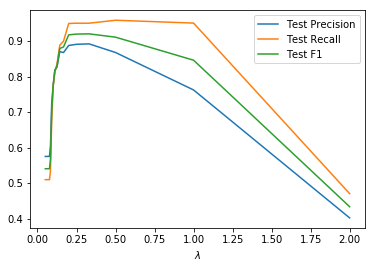

In [32]:
result_df = pd.read_csv(r"C:\phd\rpca\debug\returns_polarity_df.csv")
result_95pct_df = result_df[(result_df['Top %'] == 95) & (result_df['Lambda'] < 3)]

fig, axes = plt.subplots(ncols=1)
axes.plot(result_95pct_df['Lambda'], result_95pct_df['Test Precision'])
axes.plot(result_95pct_df['Lambda'], result_95pct_df['Test Recall'])
axes.plot(result_95pct_df['Lambda'], result_95pct_df['Test F1'])
axes.set_xlabel("$\lambda$")
axes.legend(loc='upper right')
#     axes[0].set_title('Training S&P 500 Adj Close')
#     axes[0].xaxis_date()
#     axes[0].set_ylim(600, 3000)
#     date_format = mdates.DateFormatter('%m/%y')
#     axes[0].xaxis.set_major_formatter(date_format)


In [235]:
result_95pct_df.head()

Lambda  Top %  Bottom %  Training Precision  Training Recall  \
116  0.0500   95.0       5.0            0.723462         0.723462   
117  0.0526   95.0       5.0            0.723462         0.723462   
118  0.0556   95.0       5.0            0.723462         0.723462   
119  0.0588   95.0       5.0            0.723462         0.723462   
120  0.0625   95.0       5.0            0.723462         0.723462   

     Training F1  Validation Precision  Validation Recall  Validation F1  \
116     0.723462              0.757689           0.670307       0.711324   
117     0.723462              0.757689           0.670307       0.711324   
118     0.723462              0.757689           0.670307       0.711324   
119     0.723462              0.757689           0.670307       0.711324   
120     0.723462              0.757689           0.670307       0.711324   

     Test Precision  Test Recall   Test F1  
116        0.575241     0.509844  0.540572  
117        0.575241     0.509844  0.540572  
118        0.575241     0.509844  0.540572  
119        0.575241     0.509844  0.540572  
120        0.575241     0.509844  0.540572

## Plot of Symmetrical KL-Divergence for a $\lambda$

Text(0,0.5,'S&P 500 Adj Close')

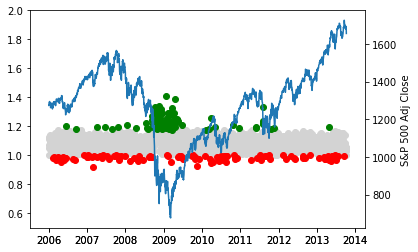

In [93]:
some_lambda_multiplier = 1
topPercentile = 95
bottomPercentile = 5

S_training_df, S_validation_df, S_test_df = get_sparse_dfs("symmetrical-kl-divergence", 
                                                            some_lambda_multiplier, 
                                                            Y_training_anomalies, 
                                                            Y_validation_anomalies, 
                                                            Y_test_anomalies, 
                                                            topPercentile, 
                                                            bottomPercentile)

fig, axes1 = plt.subplots(ncols=1)
    
normal_mask = S_training_df['Anomaly'] == 0
axes1.scatter(S_training_df.index[normal_mask], S_training_df.loc[normal_mask]['PNR'], color="lightgray")
    
positive_mask = S_training_df['Anomaly'] > 0
axes1.scatter(S_training_df.index[positive_mask], S_training_df.loc[positive_mask]['PNR'], color="green")

negative_mask = S_training_df['Anomaly'] < 0
axes1.scatter(S_training_df.index[negative_mask], S_training_df.loc[negative_mask]['PNR'], color="red")

# axes.set_title('Training Constituents Anomalies')
axes1.set_ylim(0.5, 2)
axes1.xaxis_date()
date_format = mdates.DateFormatter('%m/%y')
axes1.xaxis.set_major_formatter(date_format)

axes2 = fig.add_subplot(111, sharex=axes1, frameon=False)
axes2.plot(sp500_training_df.index, sp500_training_df['Adj Close'])
axes2.yaxis.tick_right()
axes2.yaxis.set_label_position("right")
axes2.set_ylabel("S&P 500 Adj Close")


In [44]:
output_root_dir = get_output_root_dir("training", "symmetrical-kl-divergence")
S = load_sparse_matrix(output_root_dir, some_lambda_multiplier)
# np.savetxt(r"C:\phd\rpca\debug\sparse_symm_kld_df.csv", S_training, delimiter=",")

In [92]:
data = S[-1,:]
x = data[np.where(data > TICKER_ANOMALY_THRESHOLD)]
np.sum(x)

1.0024195382657717

In [49]:
from numpy import linalg as LA

In [84]:
def get_l1_l2_norm(M):
    p_l1_norm = []
    n_l1_norm = []
    
    p_l2_norm = []
    n_l2_norm = []

    for i in np.arange(M.shape[0]):
        data = M[i,:]
        x = data[np.where(data > TICKER_ANOMALY_THRESHOLD)]
        p_l1_norm.append(LA.norm(x, 1))
        p_l2_norm.append(LA.norm(x, 2))

        x = data[np.where(data < (-1*TICKER_ANOMALY_THRESHOLD))]
        n_l1_norm.append(LA.norm(x, 1))
        n_l2_norm.append(LA.norm(x, 2))
        
    return p_l1_norm, n_l1_norm, p_l2_norm, n_l2_norm

In [88]:
np.max(S)

0.3721709038933934

In [85]:
S[abs(S) < TICKER_ANOMALY_THRESHOLD] = 0        
P = (S > 0 ).sum(axis=1)
N = (S < 0 ).sum(axis=1)
Z = (S == 0).sum(axis=1)
M = np.concatenate((P, N, Z), axis=1)
p_l1_norm, n_l1_norm, p_l2_norm, n_l2_norm = get_l1_l2_norm(S)

S_df = pd.DataFrame(M, columns=['P', 'N', 'Z'])
S_df['PNR'] = S_df['P'] / S_df['N']
S_df['P_L1'] = p_l1_norm
S_df['N_L1'] = n_l1_norm
S_df['P_L2'] = p_l2_norm
S_df['N_L2'] = n_l2_norm
S_df.head()

P    N     Z       PNR      P_L1      N_L1      P_L2      N_L2
0  395  375  1184  1.053333  0.047134  0.029306  0.135355  0.073784
1  411  370  1173  1.110811  0.042854  0.040945  0.115488  0.079916
2  384  383  1187  1.002611  0.050230  0.029682  0.109789  0.067131
3  421  374  1159  1.125668  0.052937  0.030205  0.107659  0.064118
4  422  394  1138  1.071066  0.071614  0.040574  0.138399  0.100850

In [86]:
S_df.to_csv(r"C:\phd\rpca\debug\S_df.csv")

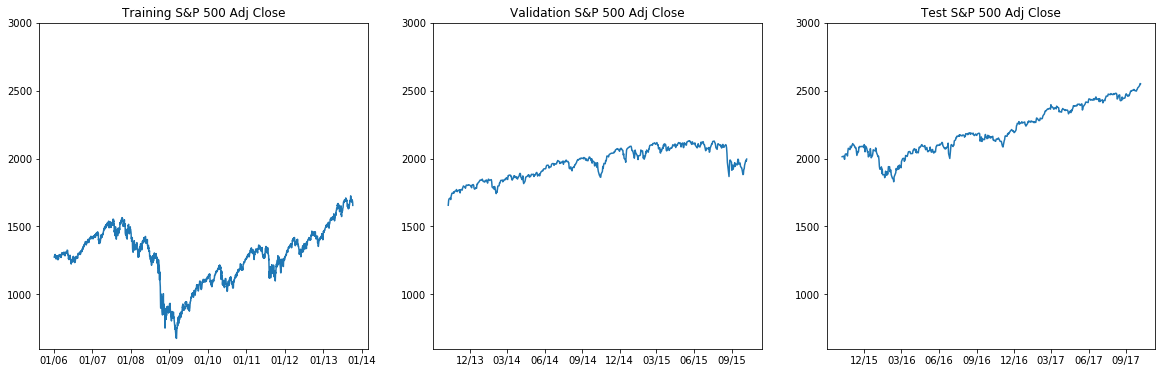

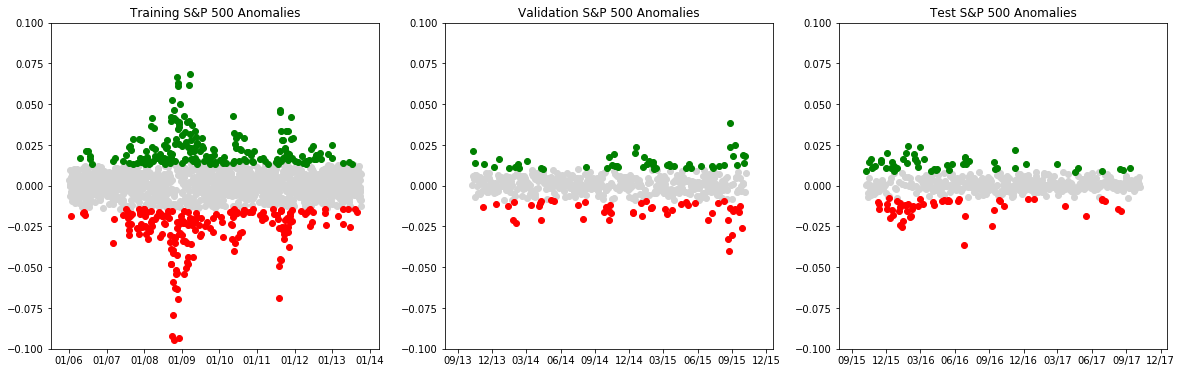

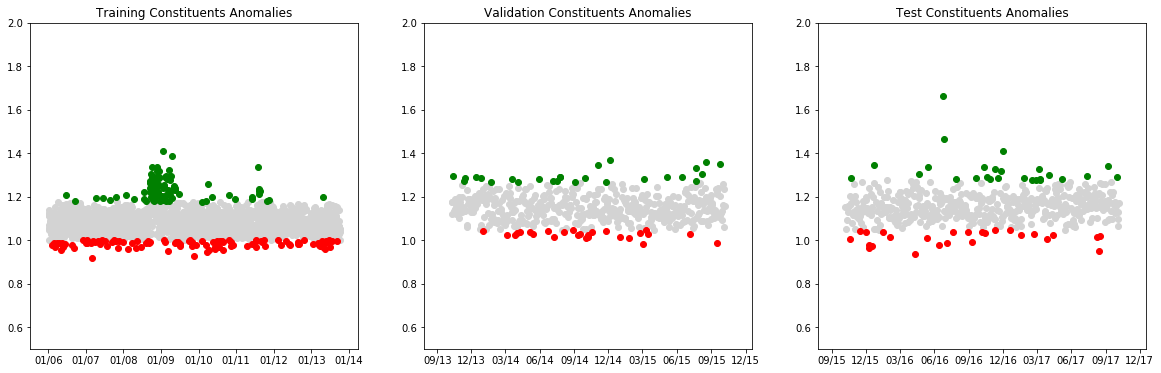

In [84]:
plot_sp500(sp500_training_df, sp500_validation_df, sp500_test_df)
plot_sp500_anomalies(Y_training_anomalies, Y_validation_anomalies, Y_test_anomalies)
plot_constituents(S_training_df, S_validation_df, S_test_df)

#### $2^{ND}$ ORDER INPUT - SYMMETRICAL KL-DIVERGENCE - DETECTING ANOMALIES

In [96]:
input_types = ["symmetrical-kl-divergence"]
dataset_types = ["training", "validation", "test"]
lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
            0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 
            6, 7, 8, 9, 10]

row_idx = 0

result_df = pd.DataFrame(columns= ['Lambda', 'Top %', 'Bottom %', 
                                   'Training Precision', 'Training Recall', 'Training F1',
                                  'Validation Precision', 'Validation Recall', 'Validation F1',
                                  'Test Precision', 'Test Recall', 'Test F1'])

for percentile in np.arange(1,11):
    topPercentile = 100 - percentile
    bottomPercentile = percentile
    Y_training_anomalies = get_sp500_anomalies(sp500_training_df.copy(), topPercentile, bottomPercentile)
    Y_validation_anomalies = get_sp500_anomalies(sp500_validation_df.copy(), topPercentile, bottomPercentile)
    Y_test_anomalies = get_sp500_anomalies(sp500_test_df.copy(), topPercentile, bottomPercentile)

    for input_type in input_types:
        print("-----------------------------------------------------------------------------")
        print("%s" % input_type)

        for lambda_multiplier in lam_list:
            print("Processing lambda = {0:.5f}, topPercentile = {1:d}%, bottomPercentile={2:d}%".format(lambda_multiplier, topPercentile, bottomPercentile))
            S_training_df, S_validation_df, S_test_df = get_sparse_dfs(input_type, 
                                                                       lambda_multiplier, 
                                                                       Y_training_anomalies, 
                                                                       Y_validation_anomalies, 
                                                                       Y_test_anomalies,
                                                                       topPercentile, 
                                                                       bottomPercentile)
            
            X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test(S_training_df.copy(), 
                                                                                S_validation_df.copy(), 
                                                                                S_test_df.copy())        

            training_precision, training_recall, training_f1 = get_metrics(y_train, X_train[:,4])
            val_precision, val_recall, val_f1 = get_metrics(y_val, X_val[:,4])
            test_precision, test_recall, test_f1 = get_metrics(y_test, X_test[:,4])

            result_df.loc[row_idx] = [lambda_multiplier, topPercentile, bottomPercentile, 
                                      training_precision, training_recall, training_f1, 
                                      val_precision, val_recall, val_f1, 
                                      test_precision, test_recall, test_f1]
            row_idx = row_idx + 1

# save the returns result data frame
result_df.to_csv(r"C:\phd\rpca\debug\symmetrical_kl_divergence_result_polarity_df.csv")

-----------------------------------------------------------------------------
symmetrical-kl-divergence
Processing lambda = 0.05000, topPercentile = 99%, bottomPercentile=1%


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Processing lambda = 0.05260, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.05560, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.05880, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.06250, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.06670, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.07140, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.07690, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.08330, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.09090, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.10000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.11110, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.12500, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.14290, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.16670, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 

C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Processing lambda = 3.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 4.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 5.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 6.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 7.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 8.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 9.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 10.00000, topPercentile = 99%, bottomPercentile=1%
-----------------------------------------------------------------------------
symmetrical-kl-divergence
Processing lambda = 0.05000, topPercentile = 98%, bottomPercentile=2%
Processing lambda = 0.05260, topPercentile = 98%, bottomPercentile=2%
Processing lambda = 0.05560, topPercentile = 98%, bottomPercentile=2%
Processing lambda = 0.05880, topPercentile = 98%, bottomPercentile=2%
Processing lambda = 0.06250, topPercentile = 98%, botto

Processing lambda = 0.33000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 0.50000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 1.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 2.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 3.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 4.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 5.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 6.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 7.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 8.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 9.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 10.00000, topPercentile = 95%, bottomPercentile=5%
-----------------------------------------------------------------------------
symmetrical-kl-divergence
Processing lambda = 0.05000, topPercentile = 94%, botto

Processing lambda = 0.14290, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.16670, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.20000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.25000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.33000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.50000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 1.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 2.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 3.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 4.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 5.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 6.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 7.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 8.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 

<hr>

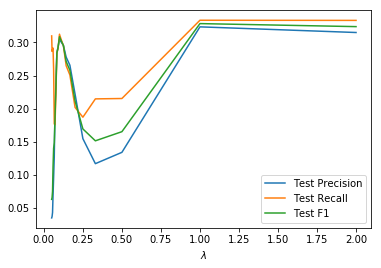

In [99]:
result_df = pd.read_csv(r"C:\phd\rpca\debug\symmetrical_kl_divergence_result_polarity_df.csv")
result_95pct_df = result_df[(result_df['Top %'] == 95) & (result_df['Lambda'] < 3)]

fig, axes = plt.subplots(ncols=1)
axes.plot(result_95pct_df['Lambda'], result_95pct_df['Test Precision'])
axes.plot(result_95pct_df['Lambda'], result_95pct_df['Test Recall'])
axes.plot(result_95pct_df['Lambda'], result_95pct_df['Test F1'])
axes.set_xlabel("$\lambda$")
axes.legend(loc='lower right')

## Plot of <font color="red">Asymmetrical</font> KL-Divergence for a $\lambda$

Text(0,0.5,'S&P 500 Adj Close')

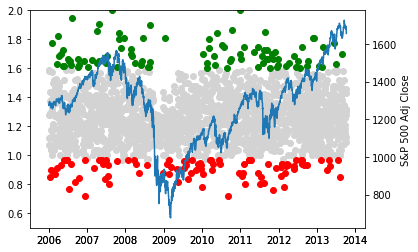

In [104]:
some_lambda_multiplier = 1
topPercentile = 95
bottomPercentile = 5

S_training_df, S_validation_df, S_test_df = get_sparse_dfs("asymmetrical-kl-divergence", 
                                                            some_lambda_multiplier, 
                                                            Y_training_anomalies, 
                                                            Y_validation_anomalies, 
                                                            Y_test_anomalies, 
                                                            topPercentile, 
                                                            bottomPercentile)

fig, axes1 = plt.subplots(ncols=1)
    
normal_mask = S_training_df['Anomaly'] == 0
axes1.scatter(S_training_df.index[normal_mask], S_training_df.loc[normal_mask]['PNR'], color="lightgray")
    
positive_mask = S_training_df['Anomaly'] > 0
axes1.scatter(S_training_df.index[positive_mask], S_training_df.loc[positive_mask]['PNR'], color="green")

negative_mask = S_training_df['Anomaly'] < 0
axes1.scatter(S_training_df.index[negative_mask], S_training_df.loc[negative_mask]['PNR'], color="red")

# axes.set_title('Training Constituents Anomalies')
axes1.set_ylim(0.5, 2)
axes1.xaxis_date()
date_format = mdates.DateFormatter('%m/%y')
axes1.xaxis.set_major_formatter(date_format)

axes2 = fig.add_subplot(111, sharex=axes1, frameon=False)
axes2.plot(sp500_training_df.index, sp500_training_df['Adj Close'])
axes2.yaxis.tick_right()
axes2.yaxis.set_label_position("right")
axes2.set_ylabel("S&P 500 Adj Close")


In [ ]:
output_root_dir = get_output_root_dir("training", "asymmetrical-kl-divergence")
S = load_sparse_matrix(output_root_dir, some_lambda_multiplier)

In [106]:
S_training_df.to_csv(r"C:\phd\rpca\debug\asymm_kld_S_training_df.csv")

In [104]:
S_training_df.to_csv(r"C:\phd\rpca\debug\S_training_df.csv")

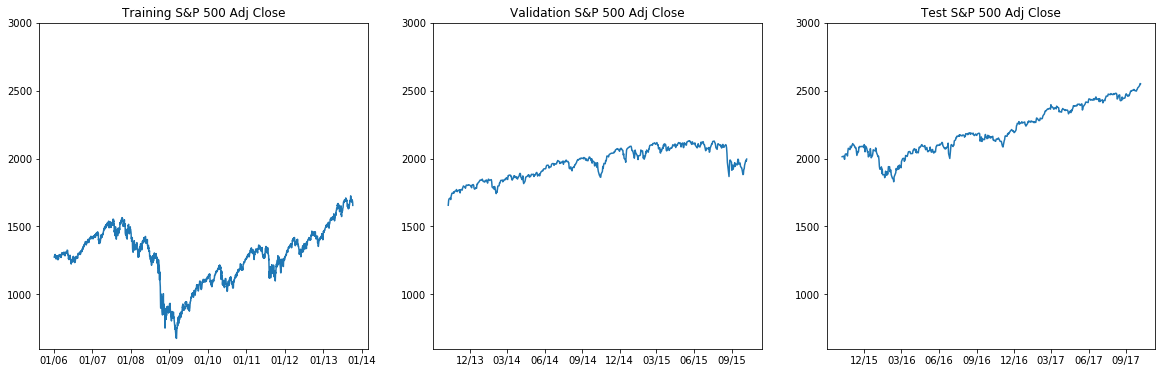

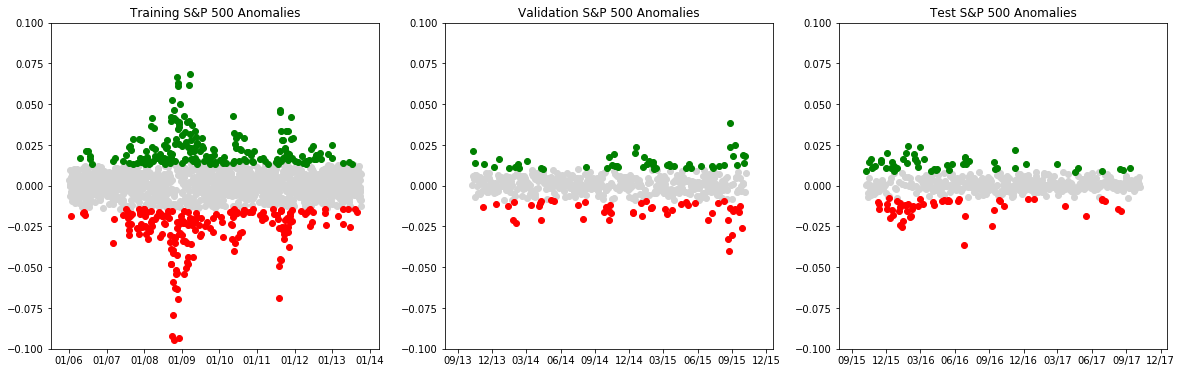

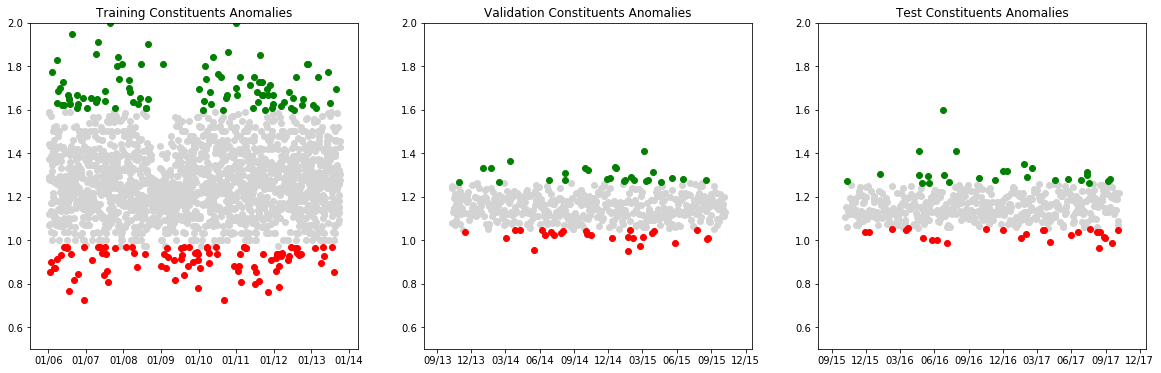

In [88]:
plot_sp500(sp500_training_df, sp500_validation_df, sp500_test_df)
plot_sp500_anomalies(Y_training_anomalies, Y_validation_anomalies, Y_test_anomalies)
plot_constituents(S_training_df, S_validation_df, S_test_df)

#### $2^{ND}$ ORDER INPUT - <font color="red">ASYMMETRICAL</font> KL-DIVERGENCE - DETECTING ANOMALIES

In [102]:
input_types = ["asymmetrical-kl-divergence"]
dataset_types = ["training", "validation", "test"]
lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
            0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 
            6, 7, 8, 9, 10]

row_idx = 0

result_df = pd.DataFrame(columns= ['Lambda', 'Top %', 'Bottom %', 
                                   'Training Precision', 'Training Recall', 'Training F1',
                                  'Validation Precision', 'Validation Recall', 'Validation F1',
                                  'Test Precision', 'Test Recall', 'Test F1'])

for percentile in np.arange(1,11):
    topPercentile = 100 - percentile
    bottomPercentile = percentile
    Y_training_anomalies = get_sp500_anomalies(sp500_training_df.copy(), topPercentile, bottomPercentile)
    Y_validation_anomalies = get_sp500_anomalies(sp500_validation_df.copy(), topPercentile, bottomPercentile)
    Y_test_anomalies = get_sp500_anomalies(sp500_test_df.copy(), topPercentile, bottomPercentile)

    for input_type in input_types:
        print("-----------------------------------------------------------------------------")
        print("%s" % input_type)

        for lambda_multiplier in lam_list:
            print("Processing lambda = {0:.5f}, topPercentile = {1:d}%, bottomPercentile={2:d}%".format(lambda_multiplier, topPercentile, bottomPercentile))
            S_training_df, S_validation_df, S_test_df = get_sparse_dfs(input_type, 
                                                                       lambda_multiplier, 
                                                                       Y_training_anomalies, 
                                                                       Y_validation_anomalies, 
                                                                       Y_test_anomalies,
                                                                       topPercentile, 
                                                                       bottomPercentile)
            
            X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test(S_training_df.copy(), 
                                                                                S_validation_df.copy(), 
                                                                                S_test_df.copy())        

            training_precision, training_recall, training_f1 = get_metrics(y_train, X_train[:,4])
            val_precision, val_recall, val_f1 = get_metrics(y_val, X_val[:,4])
            test_precision, test_recall, test_f1 = get_metrics(y_test, X_test[:,4])

            result_df.loc[row_idx] = [lambda_multiplier, topPercentile, bottomPercentile, 
                                      training_precision, training_recall, training_f1, 
                                      val_precision, val_recall, val_f1, 
                                      test_precision, test_recall, test_f1]
            row_idx = row_idx + 1

# save the returns result data frame
result_df.to_csv(r"C:\phd\rpca\debug\asymmetrical_kl_divergence_result_polarity_df.csv")

-----------------------------------------------------------------------------
asymmetrical-kl-divergence
Processing lambda = 0.05000, topPercentile = 99%, bottomPercentile=1%


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Processing lambda = 0.05260, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.05560, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.05880, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.06250, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.06670, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.07140, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.07690, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.08330, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.09090, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.10000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.11110, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.12500, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.14290, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.16670, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 

C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Processing lambda = 3.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 4.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 5.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 6.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 7.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 8.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 9.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 10.00000, topPercentile = 99%, bottomPercentile=1%
-----------------------------------------------------------------------------
asymmetrical-kl-divergence
Processing lambda = 0.05000, topPercentile = 98%, bottomPercentile=2%
Processing lambda = 0.05260, topPercentile = 98%, bottomPercentile=2%
Processing lambda = 0.05560, topPercentile = 98%, bottomPercentile=2%
Processing lambda = 0.05880, topPercentile = 98%, bottomPercentile=2%
Processing lambda = 0.06250, topPercentile = 98%, bott

Processing lambda = 0.25000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 0.33000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 0.50000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 1.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 2.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 3.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 4.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 5.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 6.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 7.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 8.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 9.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 10.00000, topPercentile = 95%, bottomPercentile=5%
-----------------------------------------------------------------------------
asymmetrica

Processing lambda = 0.11110, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.12500, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.14290, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.16670, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.20000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.25000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.33000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.50000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 1.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 2.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 3.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 4.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 5.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 6.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 

<hr>